In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy import units as u
from astropy.cosmology import Planck15
from scipy.interpolate import griddata

In [2]:
font = {'size'   : 20, 'family':'STIXGeneral'}
plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern']})
plt.rc_context({'axes.autolimit_mode': 'round_numbers'})

## Class to organize auto- and cross-spectra of components at different frequencies

In [3]:
class spectra():
    
    def __init__(self, base_dir, ellmax, freqs, comps, gg_shot_noise, CIB_model='H13', noise=None):
        self.base_dir = base_dir
        self.ellmax = ellmax
        self.freqs = freqs
        self.comps = comps
        self.gg_shot_noise = gg_shot_noise
        self.noise = noise #dimensions (nfreqs x ellmax)
        #index as all_spectra[a][i][b][j] for cross-spectrum of component a at frequency i with component b at frequency j
        self.all_spectra = np.zeros((len(comps), len(freqs), len(comps), len(freqs), ellmax+1)) 
        #index as comp_cross_g_spectra[a][i][b] for cross-spectrum component a at frequency i with g blue green red
        self.comp_cross_g_spectra = np.zeros((len(comps), len(freqs), 3, ellmax+1))
        #g_a x g_b spectra, index 0 for blue, 1 for green, 2 for red
        self.gg_spectrum = np.zeros((3,3,ellmax+1))
        #list of ells
        self.ells = np.arange(ellmax+1)
        self.CIB_model = CIB_model
    
    @staticmethod
    def get_file_name(base_dir, freq1, freq2, comp1, comp2):
        fname = f'{base_dir}/ell_dl_'
        if comp1==comp2=='CMB':
            return f'{base_dir}/ell_dl_CMB_lensed.txt'
        else:
            fname += f'{freq1}x{freq2}_GHz_{comp1}x{comp2}.txt' 
        return fname
    
    def log_interp(self, ells, spectrum):
        if np.all(spectrum >= 0):
            log_spectrum = np.log(spectrum)
            f = interp1d(ells, log_spectrum, fill_value="extrapolate", kind="linear")
            return np.exp(f(self.ells))
        else:
            log_neg_spectrum = np.log(-spectrum)
            f = interp1d(ells, log_neg_spectrum, fill_value="extrapolate", kind="linear")
            return -np.exp(f(self.ells))
    
    def cubic_interp(self, ells, spectrum):
        f = interp1d(ells, spectrum, fill_value="extrapolate", kind='cubic')
        return f(self.ells)
        
    
    
    def get_ksz_auto_spectra(self, plot=False):
        ksz_patchy_file = open(f'{self.base_dir}/FBN_kSZ_PS_patchy.d.txt', 'r')
        rows = ksz_patchy_file.readlines()
        for i, line in enumerate(rows):
            rows[i] = line.lstrip(' ').replace('\n', '').split()
        rows = np.asarray(rows, dtype=np.float32)
        cols = np.transpose(rows)
        ells_ksz_patchy, ksz_patchy = cols
        ksz_patchy = self.cubic_interp(ells_ksz_patchy, ksz_patchy)

        ksz_nonpatchy_file = open(f'{self.base_dir}/FBN_kSZ_PS.d.txt', 'r')
        rows = ksz_nonpatchy_file.readlines()
        for i, line in enumerate(rows):
            rows[i] = line.lstrip(' ').replace('\n', '').split()
        rows = np.asarray(rows, dtype=np.float32)
        cols = np.transpose(rows)
        ells_ksz_nonpatchy, ksz_nonpatchy = cols
        ksz_nonpatchy = self.cubic_interp(ells_ksz_nonpatchy, ksz_nonpatchy)

        ksz = ksz_patchy + ksz_nonpatchy

        if plot:
            plt.clf()
            plt.plot(self.ells, ksz_patchy, label='patchy')
            plt.plot(self.ells, ksz_nonpatchy, label='non-patchy')
            plt.plot(self.ells, ksz, label='total kSZ')
            plt.title('kSZ Auto-Spectra')
            plt.legend()
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$ [$\mu K^2$]')
        ksz = ksz/((self.ells)*(self.ells+1))*(2*np.pi)
        ksz[0] = 0
        return ksz
    
    def get_noise_auto_spectra(self, freq, plot=False):
        planck_noise_channels = {30, 44, 70, 100, 143, 217, 353}
        SO_noise_channels = {93, 145, 225, 280}
        if freq in SO_noise_channels:
            noise_file = open(f'{base_dir}/so_noise/noise_{freq}GHz.txt', 'r')
        else:
            noise_file = open(f'{base_dir}/planck_noise/noise_{freq}GHz.txt', 'r')
        rows = noise_file.readlines()
        for i, line in enumerate(rows):
            rows[i] = line.lstrip(' ').replace('\n', '').split()
        rows = np.asarray(rows, dtype=np.float32)
        ells_noise, noise = rows
        noise = self.cubic_interp(ells_noise, noise)
        if plot:
            plt.plot(self.ells, self.ells*(self.ells+1)*noise/(2*np.pi)) #noise needs to be put into Dl for plotting
            plt.title(f'Noise Auto-Spectrum {freq} GHz')
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$ [$\mu K^2$]')
        return noise
    
    @staticmethod
    def tsz_spectral_response(freqs): #input frequency in GHz
        T_cmb = 2.726
        h = 6.62607004*10**(-34)
        kb = 1.38064852*10**(-23)
        f = 1. #fsky
        response = []
        for freq in freqs:
            x = h*(freq*10**9)/(kb*T_cmb) #x is v/56.9 GHz
            response.append(T_cmb*(x*1/np.tanh(x/2)-4)) #was factor of tcmb microkelvin before
        return np.array(response)
    
    def cib_spectral_response(self, freqs): #input frequency in GHz
        # function from pyilc
        # CIB = modified blackbody here
        # N.B. overall amplitude is not meaningful here; output ILC map (if you tried to preserve this component) would not be in sensible units

        TCMB = 2.726 #Kelvin
        TCMB_uK = 2.726e6 #micro-Kelvin
        hplanck=6.626068e-34 #MKS
        kboltz=1.3806503e-23 #MKS
        clight=299792458.0 #MKS

        # function needed for Planck bandpass integration/conversion following approach in Sec. 3.2 of https://arxiv.org/pdf/1303.5070.pdf
        # blackbody derivative
        # units are 1e-26 Jy/sr/uK_CMB
        def dBnudT(nu_ghz):
            nu = 1.e9*np.asarray(nu_ghz)
            X = hplanck*nu/(kboltz*TCMB)
            return (2.*hplanck*nu**3.)/clight**2. * (np.exp(X))/(np.exp(X)-1.)**2. * X/TCMB_uK

        # conversion from specific intensity to Delta T units (i.e., 1/dBdT|T_CMB)
        #   i.e., from W/m^2/Hz/sr (1e-26 Jy/sr) --> uK_CMB
        #   i.e., you would multiply a map in 1e-26 Jy/sr by this factor to get an output map in uK_CMB
        def ItoDeltaT(nu_ghz):
            return 1./dBnudT(nu_ghz)

        
        if self.CIB_model == 'H13':
            Tdust_CIB = 24.0       #CIB effective dust temperature [K] (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf)
            beta_CIB = 1.2         #CIB modified blackbody spectral index (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf ; Table 10 of that paper contains CIB monopoles)
        elif self.CIB_model == 'P14':
            Tdust_CIB = 20.0       #CIB effective dust temperature [K] (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf)
            beta_CIB = 1.45         #CIB modified blackbody spectral index (Table 9 of http://www.aanda.org/articles/aa/pdf/2014/11/aa22093-13.pdf ; Table 10 of that paper contains CIB monopoles)
        nu0_CIB_ghz = 353.0    #CIB pivot frequency [GHz]
        kT_e_keV = 5.0         #electron temperature for relativistic SZ evaluation [keV] (for reference, 5 keV is rough temperature for a 3x10^14 Msun/h cluster at z=0 (e.g., Arnaud+2005))
        nu0_radio_ghz = 150.0  #radio pivot frequency [GHz]
        beta_radio = -0.5      #radio power-law index

        nu_ghz = freqs
        nu = 1.e9*np.asarray(nu_ghz).astype(float)
        X_CIB = hplanck*nu/(kboltz*Tdust_CIB)
        nu0_CIB = nu0_CIB_ghz*1.e9
        X0_CIB = hplanck*nu0_CIB/(kboltz*Tdust_CIB)
        resp = (nu/nu0_CIB)**(3.0+(beta_CIB)) * ((np.exp(X0_CIB) - 1.0) / (np.exp(X_CIB) - 1.0)) * (ItoDeltaT(np.asarray(nu_ghz).astype(float))/ItoDeltaT(nu0_CIB_ghz))
        resp[np.where(nu_ghz == None)] = 0. #this case is appropriate for HI or other maps that contain no CMB-relevant signals (and also no CIB); they're assumed to be denoted by None in nu_ghz
        return resp
    
    def get_cib_shot_noise(self):
        #from table 6 of Planck Collaboration: CIB Anisotropies with Planck
        planck_freqs = np.array([545, 353, 217, 143, 100]) #we only use 353, 217, 100
        all_freqs = np.array([545, 353, 280, 225, 217, 145, 143, 100, 93])
        shot_noise_545 = np.array([1454, 543, 135, 35, 12])
        shot_noise_353 = np.array([543, 225, 59, 15, 5.4])
        shot_noise_217 = np.array([135, 59, 16, 4.3, 1.5])
        shot_noise_143 = np.array([35, 15, 4.3, 1.2, 0.42])
        shot_noise_100 = np.array([12, 5.4, 1.5, 0.42, 0.15])
        planck_shot_noise = np.array([shot_noise_545, shot_noise_353, shot_noise_217, shot_noise_143, shot_noise_100])
        for i in range(len(planck_shot_noise)):
            for j in range(len(planck_shot_noise[0])):
                freq1, freq2 = planck_freqs[i], planck_freqs[j]
                equiv1 = u.thermodynamic_temperature(freq1 * u.GHz, Planck15.Tcmb0)
                planck_shot_noise[i][j] *= (1. * u.Jy / u.sr).to(u.uK, equivalencies=equiv1).value
                equiv2 = u.thermodynamic_temperature(freq2 * u.GHz, Planck15.Tcmb0)
                planck_shot_noise[i][j] *= (1. * u.Jy / u.sr).to(u.uK, equivalencies=equiv2).value
        
        #get planck x (planck and SO)
        planck_shot_noise_log = np.log(planck_shot_noise)
        planck_cross_all_shot_noise = np.zeros((5, len(all_freqs)))
        for i, sn in enumerate(planck_shot_noise_log):
            f = interp1d(planck_freqs, sn, fill_value='extrapolate')
            planck_cross_all_shot_noise[i] = np.exp(f(all_freqs))
        
        #get (planck and SO) x (planck and SO)
        all_cross_planck_shot_noise = planck_cross_all_shot_noise.T
        all_cross_planck_shot_noise_log = np.log(all_cross_planck_shot_noise)
        all_shot_noise = np.zeros((len(all_freqs), len(all_freqs)))
        for i, sn in enumerate(all_cross_planck_shot_noise_log):
            f = interp1d(planck_freqs, sn, fill_value='extrapolate')
            all_shot_noise[i] = np.exp(f(all_freqs))
        
        indices_to_delete = [i for i in range(len(all_shot_noise)) if all_freqs[i] not in self.freqs]
        all_shot_noise = np.delete(all_shot_noise, indices_to_delete, axis=0)
        all_shot_noise = np.delete(all_shot_noise, indices_to_delete, axis=1)
        all_shot_noise = np.flip(all_shot_noise)
        self.cib_shot_noise = all_shot_noise
        return all_shot_noise

    
    def populate_all_spectra(self, plot=False):
        
        #populate all_spectra from files, index as all_spectra[a][i][b][j]
        
        cib_shot_noise = self.get_cib_shot_noise()
        
        for a, comp1 in enumerate(self.comps):
            for i, freq1 in enumerate(self.freqs):
                plt.clf()
                for b, comp2 in enumerate(self.comps):
                    for j, freq2 in enumerate(self.freqs):
                        if comp1==comp2=='kSZ':
                            spectrum = self.get_ksz_auto_spectra()
                        elif comp1=='kSZ' or comp2=='kSZ': #kSZ cross anything is 0
                            continue
                        elif comp1==comp2=='noise':
                            if i==j:
                                if self.noise is None:
                                    spectrum = self.get_noise_auto_spectra(self.freqs[i])
                                else:
                                    spectrum = self.noise[i]
                            else:
                                spectrum = np.zeros(self.ellmax+1)
                        elif comp1=='noise' or comp2=='noise': #noise cross anything is 0
                            continue
                        elif (comp1=='CMB' or comp2=='CMB') and not (comp1=='CMB' and comp2=='CMB'): #CMB cross anything is 0
                            continue
                        elif (comp1=='radio' or comp2=='radio') and not (comp1=='radio' and comp2=='radio'): #radio cross anything is 0
                            continue
                        else:
                            try:
                                file = open(self.get_file_name(self.base_dir, freq1, freq2, comp1, comp2), 'r')
                            except FileNotFoundError:
                                file = open(self.get_file_name(self.base_dir, freq2, freq1, comp2, comp1), 'r')
                            ells_here, spectrum = np.loadtxt(file)
                            spectrum = self.cubic_interp(ells_here, spectrum)
                            spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
                            spectrum[0] = 0
                            if comp1==comp2=='CIB': #add CIB shot noise
                                spectrum += cib_shot_noise[i][j]
                        self.all_spectra[a][i][b][j] = spectrum
                        if plot:
                            plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
                if plot:
                    plt.xlabel(r'$\ell$')
                    plt.ylabel(r'$D_{\ell}$')
                    plt.legend()
                    plt.show()
        return self.all_spectra
    
    def populate_comp_cross_g_spectra(self, plot=False):
        
        #populate comp_cross_g_spectra, index as comp_cross_g_spectra[component][freq][0-2 for unWISE blue, green, or red]

        for a, comp in enumerate(self.comps):
            if comp=='kSZ' or comp=='noise' or comp=='CMB' or comp=='radio':
                continue
            for i, freq in enumerate(self.freqs):
                for b, color in enumerate(['g_blue', 'g_green', 'g_red']):
                    file = open(f'{self.base_dir}/ell_dl_{freq}x{freq}_GHz_{comp}xg_wLensmag_{color[2:]}.txt', 'r')
                    ells_here, spectrum = np.loadtxt(file)
                    f_spectrum = interp1d(ells_here, spectrum, fill_value="extrapolate")
                    spectrum = f_spectrum(self.ells)
                    spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
                    spectrum[0] = 0
                    self.comp_cross_g_spectra[a][i][b] = spectrum
                    if plot:
                        plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp} {freq} GHz x {color}')
        if plot:
            plt.clf()
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$')
            plt.legend()
            plt.show()
        return self.comp_cross_g_spectra 
    
    def populate_gg_spectrum(self, plot=False):

        #populate gg auto- and cross-spectra index as gg_spectrum[a][b][l] where a and b index unWISE blue, green, red

        plt.clf()
        for a, color1 in enumerate(['blue', 'green', 'red']):
            for b, color2 in enumerate(['blue', 'green', 'red']):
                file = open(f'{self.base_dir}/ell_dl_gxg_wLensmag_{color1}_x_{color2}.txt', 'r')
                ells_gg, gg = np.loadtxt(file)
                f_gg = interp1d(ells_gg, gg, fill_value="extrapolate")
                gg = f_gg(self.ells)
                if color1==color2=='blue':
                    self.blue_gg = gg
                gg_shot_noise = self.gg_shot_noise[a][b]
                if plot:
                    plt.plot(self.ells, gg, label='gg signal')
                    plt.plot(self.ells, self.ells*(self.ells+1)*gg_shot_noise/(2*np.pi), label='gg shot noise')
                    plt.plot(self.ells, gg+self.ells*(self.ells+1)*gg_shot_noise/(2*np.pi), label='total gg spectrum')
                    plt.title(f'gg {color1} x {color2} Spectrum')
                    plt.xlabel(r'$\ell$')
                    plt.ylabel(r'$D_{\ell}$ [$\mu K^2$]')
                    plt.yscale('log')
                    plt.legend()
                    plt.show()
                self.gg_spectrum[a][b] = gg/(self.ells*(self.ells+1))*(2*np.pi)
                self.gg_spectrum[a][b][0] = 0
                self.gg_spectrum[a][b] += gg_shot_noise
        return self.gg_spectrum
    
    def get_cls(self, plot=False):
        self.populate_all_spectra(plot=plot)
        self.populate_comp_cross_g_spectra(plot=plot)
        self.populate_gg_spectrum(plot=plot)
        self.Clij = np.einsum('aibjl->ijl', self.all_spectra) #index as Clij[i][j][l]
        self.Clig = np.einsum('aibl->ibl', self.comp_cross_g_spectra) #index as Clig[i][b][l]
        self.Clgg = self.gg_spectrum #index as Clgg[a][b][l]
        if plot:
            plt.clf()
            for i in range(len(freqs)):
                for j in range(len(freqs)):
                    plt.plot(self.ells, self.ells*(self.ells+1)*self.Clij[i][j]/(2*np.pi), label=r'$D_{\ell}$ '+f'{freqs[i]}, {freqs[j]}')
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$')
            plt.title(r'$D_{\ell}^{ij}$')
            plt.yscale('log')
            plt.legend()
            plt.show()

            plt.clf()
            for i in range(len(freqs)):
                for b in range(3):
                    plt.plot(self.ells, self.ells*(self.ells+1)*self.Clig[i][b]/(2*np.pi), label=f'{freqs[i]} GHz, color {b}')
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$')
            plt.title(r'$D_{\ell}^{ig}$')
            plt.legend()
            plt.show()

            plt.clf()
            for a in range(3):
                for b in range(3):
                    plt.plot(self.ells, self.ells*(self.ells+1)*self.Clgg[a][b]/(2*np.pi), label=f'colors {a} and {b}')
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$')
            plt.legend()
            plt.title(r'$D_{\ell}^{gg}$')
            plt.yscale('log')
            plt.show()
        return self.Clij, self.Clig, self.Clgg

## Class for performing ILC (preserved kSZ, deprojected tSZ) but with no CIB component and no constraints on g

In [4]:
class ILC_no_CIB_no_g():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        cib_idx = self.comps.index('CIB')
        self.all_spectra = np.delete(np.copy(spectra.all_spectra), (cib_idx), axis=0)
        self.all_spectra = np.delete(self.all_spectra, (cib_idx), axis=2)
        self.Clij = np.einsum('aibjl->ijl', self.all_spectra) #index as Clij[i][j][l]
        self.spectra = spectra
        self.deltal = deltal
    
    def get_Rlij(self):
        #Construct Rlij covariance matrix
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1)) 
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def get_Rlij_inv(self): 
        #Get inverse of R_{\ell}^{ij '}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) 
        return self.Rlij_inv #index as Rlij_inv[l][i][j]
        
    def get_ab(self):
        #get spectral response vectors
        self.a = np.ones(len(self.freqs)) #index as a[i]
        self.b = self.spectra.tsz_spectral_response(self.freqs) #index as b[i]
        return self.a, self.b
    
    def get_ABD(self):
        self.A = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.a)
        self.B = np.einsum('lij,i,j->l', self.Rlij_inv, self.b, self.b)
        self.D = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.b)
        return self.A, self.B, self.D
    
    def weights(self):
        #get weights
        numerator = np.einsum('lij,l,i->jl', self.Rlij_inv, self.B, self.a) \
                    - np.einsum('lij,l,i->jl', self.Rlij_inv, self.D, self.b)
        denominator = np.einsum('l,l->l', self.A, self.B) - np.einsum('l,l->l', self.D, self.D)
        self.w = numerator/denominator #index as w[i][l]
        return self.w
    
    def ILC_auto_spectrum(self, plot=False):
        self.get_Rlij()
        self.get_Rlij_inv()
        self.get_ab()
        self.get_ABD()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij) 
        if plot:
            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clyy/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (tSZ-deprojected ILC with no CIB)')
            plt.yscale('log')
            plt.show()
        return self.Clyy
        

## Class for performing ILC (preserved kSZ, deprojected tSZ) with all components including CIB but no constraints on g

In [5]:
class ILC_no_g():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.spectra = spectra
        self.Clij = spectra.Clij
        self.deltal = deltal
    
    def get_Rlij(self):
        #Construct Rlij
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1)) 
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def get_Rlij_inv(self): 
        #Get inverse of R_{\ell}^{ij '}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) 
        return self.Rlij_inv #index as Rlij_inv[l][i][j]
        
    def get_ab(self):
        #get spectral response vectors
        self.a = np.ones(len(self.freqs)) #index as a[i]
        self.b = self.spectra.tsz_spectral_response(self.freqs) #index as b[i]
        return self.a, self.b
    
    def get_ABD(self):
        self.A = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.a)
        self.B = np.einsum('lij,i,j->l', self.Rlij_inv, self.b, self.b)
        self.D = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.b)
        return self.A, self.B, self.D
    
    def weights(self):
        #get weights
        numerator = np.einsum('lij,l,i->jl', self.Rlij_inv, self.B, self.a) \
                    - np.einsum('lij,l,i->jl', self.Rlij_inv, self.D, self.b)
        denominator = np.einsum('l,l->l', self.A, self.B) - np.einsum('l,l->l', self.D, self.D)
        self.w = numerator/denominator #index as w[i][l]
        return self.w
    
    def ILC_auto_spectrum(self, plot=False):
        self.get_Rlij()
        self.get_Rlij_inv()
        self.get_ab()
        self.get_ABD()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij) 
        if plot:
            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clyy/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (tSZ-deprojected ILC)')
            plt.yscale('log')
            plt.show()
        return self.Clyy
        

## Class for de-CIBing Method

In [6]:
class de_CIB():
    
    def __init__(self, spectra, deltal, alt_spectra=None):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.spectra = spectra
        self.Clij = spectra.Clij
        self.Clig = spectra.Clig
        self.Clgg = spectra.Clgg
        self.deltal = deltal
        self.alt_spectra = alt_spectra if alt_spectra else spectra
        self.alt_Clij = alt_spectra.Clij if alt_spectra else spectra.Clij
        self.alt_Clig = alt_spectra.Clig if alt_spectra else spectra.Clig
        self.alt_Clgg = alt_spectra.Clgg if alt_spectra else spectra.Clgg
    
    def get_ILC_no_g(self):
        #get weights from a tSZ-deprojected ILC
        ILC = ILC_no_g(self.spectra, self.deltal)
        self.ILC_auto_spectrum = ILC.ILC_auto_spectrum()
        self.w = ILC.w

    
    def get_rho_ab(self):
        #get correlation matrix of tracers
        self.rho_ab = np.zeros((3,3,self.ellmax+1)) #index as rho[a][b][l]
        for a in range(3):
            for b in range(3):
                self.rho_ab[a][b] = self.alt_Clgg[a][b]/np.sqrt(self.alt_Clgg[a][a]*self.alt_Clgg[b][b])
  
    def get_rho_ab_inv(self):
        #invert correlation matrix of tracers
        rho_ab_T = np.transpose(self.rho_ab, (2,0,1))
        self.rho_ab_inv = np.array([np.linalg.inv(rho_ab_T[l]) for l in range(self.ellmax+1)])
        self.rho_ab_inv = np.transpose(self.rho_ab_inv, (1,2,0))
    
    def get_rho_ILC(self):
        #get correlation matrix of tracers with the ILC
        self.rho_ILC = np.zeros((3, self.ellmax+1)) #index as rho[ b (tracer) ][l]
        for b in range(3):
            for i in range(len(freqs)):
                self.rho_ILC[b] = np.einsum('il,il->l', self.w, self.alt_spectra.Clig[:,b,:])/np.sqrt(self.ILC_auto_spectrum * self.alt_Clgg[b,b])
    
    def get_c(self):
        #get optimal coefficients for each tracer sample to maximize correlation with the ILC map
        self.c = np.zeros((3, self.ellmax+1)) #index as c[a][l]
        self.c = np.einsum('abl,bl,l,aal->al', self.rho_ab_inv, self.rho_ILC, np.sqrt(self.ILC_auto_spectrum), 1/np.sqrt(self.alt_Clgg))
        #values of c may artificially give correlation coefficients above 1 for low ell at high frequencies
        corr = np.einsum('al,il,ial->l', self.c, self.w, self.alt_spectra.Clig) / np.sqrt(self.ILC_auto_spectrum*np.einsum('al,bl,abl->l', self.c,self.c,self.alt_Clgg))
        if len(corr[corr>=0.95]) != 0:
            max_ell_invalid_corr = np.amax(np.where(corr >= 0.95))
            self.c[:,:max_ell_invalid_corr+1] = 0.
            best_g = np.argmax(self.rho_ILC[:,:max_ell_invalid_corr+1], axis=0) #(max_ell_invalid_corr, )
            for l in range(max_ell_invalid_corr+1):
                a = best_g[l]
                self.c[a,l] = 1.
                
    def get_f(self):
        #get "optimal filter"
        num = np.einsum('al,il,ial->l', self.c, self.w, self.alt_spectra.Clig)
        denom = np.einsum('al,bl,abl->l', self.c, self.c, self.alt_Clgg)
        self.f = num/denom #index as f[l]
        
  
    
    def auto_spectrum(self, plot=False):
        self.get_ILC_no_g()
        self.get_rho_ab()
        self.get_rho_ab_inv()
        self.get_rho_ILC()
        self.get_c()
        self.get_f()
        
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij)
        self.Clyy -= np.einsum('jl,l,al,jal->l', self.w, self.f, self.c, self.Clig) 
        self.Clyy -= np.einsum('il,l,al,ial->l', self.w, self.f, self.c, self.Clig) 
        self.Clyy += np.einsum('l,l,al,bl,abl->l', self.f, self.f, self.c, self.c, self.Clgg)
        if plot:
            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clyy/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (de-CIB)')
            plt.yscale('log')
            plt.show()
        return self.Clyy
        

## Class for Standard ILC (preserved kSZ, no tSZ deprojection, no g) with all components

In [7]:
class standard_ILC():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.spectra = spectra
        self.Clij = spectra.Clij
        self.deltal = deltal
    
    def get_Rlij(self):
        #Construct Rlij
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1)) 
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def get_Rlij_inv(self): 
        #Get inverse of R_{\ell}^{ij '}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) 
        return self.Rlij_inv #index as Rlij_inv[l][i][j]
        
    def get_ab(self):
        #get spectral response vector
        self.a = np.ones(len(self.freqs)) #index as a[i]
        return self.a
    
    
    def weights(self):
        #get weights
        numerator = np.einsum('lij,j->il', self.Rlij_inv, self.a)
        denominator = np.einsum('lkm,k,m->l', self.Rlij_inv, self.a, self.a)
        self.w = numerator/denominator #index as w[i][l]
        return self.w
    
    def ILC_auto_spectrum(self, plot=False):
        self.get_Rlij()
        self.get_Rlij_inv()
        self.get_ab()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij) 
        if plot:
            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clyy/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (Standard ILC)')
            plt.show()
        return self.Clyy
        

## Class for Standard ILC (preserved kSZ, no deprojected tSZ, no constraints on g) but with no CIB or tSZ component

In [8]:
class standard_ILC_noCIB_notSZ():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        cib_idx = self.comps.index('CIB')
        tsz_idx = self.comps.index('tSZ')
        self.all_spectra = np.delete(np.copy(spectra.all_spectra), (cib_idx, tsz_idx), axis=0)
        self.all_spectra = np.delete(self.all_spectra, (cib_idx, tsz_idx), axis=2)
        self.Clij = np.einsum('aibjl->ijl', self.all_spectra) #index as Clij[i][j][l]
        self.spectra = spectra
        self.deltal = deltal
    
    def get_Rlij(self):
        #Construct Rlij
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1)) 
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def get_Rlij_inv(self): 
        #Get inverse of R_{\ell}^{ij '}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) 
        return self.Rlij_inv #index as Rlij_inv[l][i][j]
        
    def get_ab(self):
        #get spectral response vector
        self.a = np.ones(len(self.freqs)) #index as a[i]
        return self.a
    
    
    def weights(self):
        #get weights
        numerator = np.einsum('lij,j->il', self.Rlij_inv, self.a)
        denominator = np.einsum('lkm,k,m->l', self.Rlij_inv, self.a, self.a)
        self.w = numerator/denominator #index as w[i][l]
        return self.w
    
    def ILC_auto_spectrum(self, plot=False):
        self.get_Rlij()
        self.get_Rlij_inv()
        self.get_ab()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij) 
        if plot:
            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clyy/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (Standard ILC without CIB or tSZ)')
            plt.show()
        return self.Clyy
        

## Class for de-(CIB+tSZ) Method

In [9]:
class de_CIBplustSZ():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.spectra = spectra
        self.Clij = spectra.Clij
        self.Clig = spectra.Clig
        self.Clgg = spectra.Clgg
        self.deltal = deltal
    
    def get_rho_ab(self):
        #get correlation matrix of tracers
        self.rho_ab = np.zeros((3,3,self.ellmax+1)) #index as rho[a][b][l]
        for a in range(3):
            for b in range(3):
                self.rho_ab[a][b] = self.Clgg[a][b]/np.sqrt(self.Clgg[a][a]*self.Clgg[b][b])
    
    def get_rho_ab_inv(self):
        #invert correlation matrix of tracers
        rho_ab_T = np.transpose(self.rho_ab, (2,0,1))
        self.rho_ab_inv = np.array([np.linalg.inv(rho_ab_T[l]) for l in range(self.ellmax+1)])
        self.rho_ab_inv = np.transpose(self.rho_ab_inv, (1,2,0))
    
    def get_rho_cibplustsz(self):
        #get correlation matrix of tracer samples with (CIB+tSZ)
        self.rho_cibplustsz = np.zeros((3,len(self.freqs), self.ellmax+1)) #index as rho[b][i for CIB/tSZ freq][l]
        cib_idx = self.comps.index('CIB')
        tsz_idx = self.comps.index('tSZ')
        for b in range(3):
            for i in range(len(freqs)):
                self.rho_cibplustsz[b][i] = (self.spectra.comp_cross_g_spectra[cib_idx][i][b] + self.spectra.comp_cross_g_spectra[tsz_idx][i][b] ) / np.sqrt( (self.spectra.all_spectra[cib_idx,i,cib_idx,i] + self.spectra.all_spectra[tsz_idx,i,tsz_idx,i] + 2*self.spectra.all_spectra[cib_idx,i,tsz_idx,i])  * self.Clgg[b,b])
    
    def get_c(self):
        #get optimal coefficients of tracer samples to maximize correlation with (CIB+tSZ)
        self.c = np.zeros((len(self.freqs), 3, self.ellmax+1)) #index as c[i][a][l]
        cib_idx = self.comps.index('CIB')
        tsz_idx = self.comps.index('tSZ')
        self.c = np.einsum('abl,bil,iil,aal->ial', self.rho_ab_inv, self.rho_cibplustsz, np.sqrt(self.spectra.all_spectra[cib_idx,:,cib_idx,:,:] + self.spectra.all_spectra[tsz_idx,:,tsz_idx,:,:] + 2*self.spectra.all_spectra[tsz_idx,:,cib_idx,:,:]), 1/np.sqrt(self.Clgg))
        #values of c may artificially give correlation coefficients above 1 for low ell at high frequencies
        corr = np.einsum('al,al->l', self.c[-1], self.spectra.comp_cross_g_spectra[cib_idx][-1] + self.spectra.comp_cross_g_spectra[tsz_idx][-1]) / np.sqrt((self.spectra.all_spectra[cib_idx][-1][cib_idx][-1]+self.spectra.all_spectra[tsz_idx][-1][tsz_idx][-1]+2*self.spectra.all_spectra[tsz_idx][-1][cib_idx][-1])*np.einsum('al,bl,abl->l', self.c[-1],self.c[-1],self.Clgg))
        if len(corr[corr>=0.95]) != 0:
            max_ell_invalid_corr = np.amax(np.where(corr >= 0.95))
            self.c[:,:,:max_ell_invalid_corr+1] = 0.
            best_g = np.argmax(self.rho_cibplustsz[:,:,:max_ell_invalid_corr+1], axis=0) #(nfreqs, max_ell_invalid_corr)
            for i, freq in enumerate(self.freqs):
                for l in range(max_ell_invalid_corr+1):
                    a = best_g[i,l]
                    self.c[i,a,l] = 1.
                
    def get_f(self):
        #get "optimal filter"
        cib_idx = self.spectra.comps.index('CIB')
        tsz_idx = self.comps.index('tSZ')
        num = np.einsum('ial,ial->il', self.c, (self.spectra.comp_cross_g_spectra[cib_idx] + self.spectra.comp_cross_g_spectra[tsz_idx]))
        denom = np.einsum('ial,ibl,abl->il', self.c, self.c, self.Clgg)
        self.f = num/denom #index as f[i][l]   
        
    
    def get_Rlij(self):
        #Construct Rlij
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij) \
            - np.einsum('l,jl,jal,ial->ijl', prefactor, self.f, self.c, self.Clig) \
            - np.einsum('l,il,ial,jal->ijl', prefactor, self.f, self.c, self.Clig) \
            + np.einsum('l,il,jl,ial,jbl,abl->ijl', prefactor, self.f, self.f, self.c, self.c, self.Clgg)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1)) 
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def get_Rlij_inv(self): 
        #Get inverse of R_{\ell}^{ij '}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) 
        return self.Rlij_inv #index as Rlij_inv[l][i][j]
        
    def get_ab(self):
        #get spectral response vector
        self.a = np.ones(len(self.freqs)) #index as a[i]
        return self.a
    
    
    def weights(self):
        #get weights
        numerator = np.einsum('lij,j->il', self.Rlij_inv, self.a)
        denominator = np.einsum('lkm,k,m->l', self.Rlij_inv, self.a, self.a)
        self.w = numerator/denominator #index as w[i][l]
        return self.w
  
    
    def auto_spectrum(self, plot=False):
        self.get_rho_ab()
        self.get_rho_ab_inv()
        self.get_rho_cibplustsz()
        self.get_c()
        self.get_f()
        
        self.get_Rlij()
        self.get_Rlij_inv()
        self.get_ab()
        self.w = self.weights()
        
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij)
        self.Clyy -= np.einsum('il,jl,il,ial,jal->l', self.w, self.w, self.f, self.c, self.Clig) 
        self.Clyy -= np.einsum('il,jl,jl,jal,ial->l', self.w, self.w, self.f, self.c, self.Clig) 
        self.Clyy += np.einsum('il,jl,il,jl,ial,jbl,abl->l', self.w, self.w, self.f, self.f, self.c, self.c, self.Clgg)
        if plot:
            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clyy/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (de-(CIB+tSZ))')
            plt.yscale('log')
            plt.show()
        return self.Clyy
        

## Class for ILC adding g maps as frequency maps

In [10]:
class g_freq_maps():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.Clij = spectra.Clij #index as Clij[i][j][l]
        self.Clig = spectra.Clig #index as Clig[i][b][l]
        self.Clgg = spectra.Clgg #index as Clgg[a][b][l]
        self.spectra = spectra
        self.deltal = deltal
    
    def get_Rlij_prime(self):
        #Construct Rlij_prime
        nfreqs = len(self.freqs)
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        x_no_binning = np.einsum('l,ibl->ibl', prefactor, self.Clig)
        alpha_no_binning = np.einsum('l,abl->abl', prefactor, self.Clgg)
        self.Rlij_prime = np.zeros((nfreqs+3, nfreqs+3, self.ellmax+1)) #+3 after nfreqs is for g row/col
        for i in range(nfreqs+3):
            for j in range(nfreqs+3):
                if i >= nfreqs and j >= nfreqs: 
                    self.Rlij_prime[i][j] = (np.convolve(alpha_no_binning[i-nfreqs][j-nfreqs], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
                    continue
                elif i >= nfreqs:
                    self.Rlij_prime[i][j] = (np.convolve(x_no_binning[j][i-nfreqs], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
                    continue
                elif j >= nfreqs:
                    self.Rlij_prime[i][j] = (np.convolve(x_no_binning[i][j-nfreqs], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
                    continue
                self.Rlij_prime[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij_prime
    
    def get_Rlij_prime_inv(self): 
        #Get inverse of R_{\ell}^{ij '}
        self.Rlij_prime_inv = np.array([np.linalg.inv(self.Rlij_prime[:,:,l]) for l in range(self.ellmax+1)]) 
        return self.Rlij_prime_inv #index as Rlij_prime_inv[l][i][j]
        
    def get_aprime(self):
        #get spectral response vector
        a = np.ones(len(self.freqs)) #index as a[i]
        self.a_prime = np.concatenate((a, [0,0,0]), axis=None)
        return self.a_prime
    
    
    def weights(self):
        #get weights
        numerator = np.einsum('lij,j->il', self.Rlij_prime_inv, self.a_prime)
        denominator = np.einsum('lkm,k,m->l', self.Rlij_prime_inv, self.a_prime, self.a_prime)
        self.w = numerator/denominator #index as w[i][l]
        return self.w
    
    def ILC_auto_spectrum(self, plot=False):
        self.get_Rlij_prime()
        self.get_Rlij_prime_inv()
        self.get_aprime()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w[:-3], self.w[:-3], self.Clij) \
                + 2*np.einsum('il,bl,ibl->l', self.w[:-3], self.w[-3:], self.Clig) \
                + np.einsum('al,bl,abl->l', self.w[-3:], self.w[-3:], self.Clgg)
        if plot:
            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clyy/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (ILC with $g$ freq maps)')
            plt.yscale('log')
            plt.show()
        return self.Clyy
        

## Class for ILC that deprojects both tSZ and CIB

In [11]:
class ILC_deproj_tSZ_and_CIB():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.Clij = spectra.Clij
        self.spectra = spectra
        self.deltal = deltal
    
    def get_Rlij(self):
        #Get R_{\ell}^{ij}
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1))
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def get_Rlij_inv(self):
        #get inverse of R_{\ell}^{ij}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) #index as Rlij_inv[l][i][j]
        return self.Rlij_inv
    
    def get_abc(self):
        #get spectral response vectors
        self.a = np.ones(len(self.freqs)) #index as a[i]
        self.b = self.spectra.tsz_spectral_response(self.freqs) #index as b[i]
        self.c = self.spectra.cib_spectral_response(self.freqs) #index as c[i]
        return self.a, self.b, self.c
    
    def get_ABCDEFQ(self):
        self.A = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.a)
        self.B = np.einsum('lij,i,j->l', self.Rlij_inv, self.b, self.b)
        self.C = np.einsum('lij,i,j->l', self.Rlij_inv, self.c, self.c)
        self.D = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.b)
        self.E = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.c)
        self.F = np.einsum('lij,i,j->l', self.Rlij_inv, self.b, self.c)
        self.Q = np.einsum('l,l,l->l', self.A, self.B, self.C) + 2*np.einsum('l,l,l->l', self.D, self.E, self.F) \
            - np.einsum('l,l,l->l', self.A, self.F, self.F) - np.einsum('l,l,l->l', self.B, self.E, self.E) \
            - np.einsum('l,l,l->l', self.C, self.D, self.D)
        self.Q[0] = 1
        return self.A, self.B, self.C, self.D, self.E, self.F, self.Q
    
    def weights(self):
        #Define weights
        self.w = np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.B, self.C, self.a) \
            - np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.F, self.F, self.a) \
            + np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.E, self.F, self.b) \
            - np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.C, self.D, self.b) \
            + np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.D, self.F, self.c) \
            - np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.B, self.E, self.c)
        return self.w
    
    def ILC_auto_spectrum(self, plot=False):
        self.get_Rlij()
        self.get_Rlij_inv()
        self.get_abc()
        self.get_ABCDEFQ()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij)
        if plot:
            plt.clf()
            plt.plot(self.ells[2:], (self.ells*(self.ells+1)*self.Clyy/(2*np.pi))[2:])
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{T}\hat{T}}$ (ILC, deproj tSZ and CIB)')
            plt.show()
        return self.Clyy
        
        

## Class for Explicit Deprojection of g (with maximal CIB correlation) in the ILC (no tSZ deprojection)

In [12]:
class ExplicitDeprojg_CIB():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.Clij = spectra.Clij
        self.Clig = spectra.Clig
        self.Clgg = spectra.Clgg
        self.spectra = spectra
        self.deltal = deltal
    
    def get_Rlij(self):
        #Get R_{\ell}^{ij}
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1))
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def get_Rlij_inv(self):
        #get inverse of R_{\ell}^{ij}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) #index as Rlij_inv[l][i][j]
        return self.Rlij_inv

    
    def get_rho_ab(self):
        #get correlation matrix of tracer samples
        self.rho_ab = np.zeros((3,3,self.ellmax+1)) #index as rho[a][b][l]
        for a in range(3):
            for b in range(3):
                self.rho_ab[a][b] = self.Clgg[a][b]/np.sqrt(self.Clgg[a][a]*self.Clgg[b][b])
                        
    def get_rho_ab_inv(self):
        #get inverse of correlation matrix of tracer samples
        rho_ab_T = np.transpose(self.rho_ab, (2,0,1))
        self.rho_ab_inv = np.array([np.linalg.inv(rho_ab_T[l]) for l in range(self.ellmax+1)])
        self.rho_ab_inv = np.transpose(self.rho_ab_inv, (1,2,0))
    
    def get_rho_cib(self):
        #get correlation matrix of tracer samples with a^{CIB}
        i = 7 #reference frequency
        self.rho_cib = np.zeros((3, self.ellmax+1)) #index as rho[b][l]
        cib_idx = self.comps.index('CIB')
        cibxcib = self.spectra.all_spectra[cib_idx,i,cib_idx,i]/self.spectra.cib_spectral_response(self.freqs[i:i+1])**2
        cibxg_a = self.spectra.comp_cross_g_spectra[cib_idx][i]/self.spectra.cib_spectral_response(self.freqs[i:i+1])
        for b in range(3):
            self.rho_cib[b] = cibxg_a[b]/np.sqrt(cibxcib * self.Clgg[b,b])
    
    def get_coeffs(self):
        #get coefficients of tracer samples that maximize correlation with a^{CIB} (approx frequency-independent version of CIB)
        i = 7 #reference frequency
        self.coeffs = np.zeros((3, self.ellmax+1)) #index as coeffs[a][l]
        cib_idx = self.comps.index('CIB')
        cibxg_a = self.spectra.comp_cross_g_spectra[cib_idx][i]/self.spectra.cib_spectral_response(self.freqs[i:i+1])
        cibxcib = self.spectra.all_spectra[cib_idx,i,cib_idx,i]/self.spectra.cib_spectral_response(self.freqs[i:i+1])**2
        self.coeffs = np.einsum('abl,bl,l,aal->al', self.rho_ab_inv, self.rho_cib, np.sqrt(cibxcib), 1/np.sqrt(self.Clgg))
        #values of coeffs may artificially give correlation coefficients above 1 for low ell at high frequencies
        corr = np.einsum('al,al->l', self.coeffs, cibxg_a) / np.sqrt(cibxcib*np.einsum('al,bl,abl->l', self.coeffs, self.coeffs, self.Clgg))
        if len(corr[corr>=0.95]) != 0:
            max_ell_invalid_corr = np.amax(np.where(corr >= 0.95))
            self.coeffs[:,:max_ell_invalid_corr+1] = 0.
            best_g = np.argmax(self.rho_cib[:,:max_ell_invalid_corr+1], axis=0) #(max_ell_invalid_corr, )
            for l in range(max_ell_invalid_corr+1):
                a = best_g[l]
                self.coeffs[a,l] = 1.
    
    
    def get_abc(self):
        #get spectral response vectors
        self.a = np.ones(len(self.freqs)) #index as a[i]
        self.c = np.einsum('al,ial->il', self.coeffs, self.Clig) #index as c[i][l]
        return self.a, self.c
    
    def get_ABD(self):
        self.A = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.a)
        self.B = np.einsum('lij,il,jl->l', self.Rlij_inv, self.c, self.c)
        self.D = np.einsum('lij,i,jl->l', self.Rlij_inv, self.a, self.c)
        return self.A, self.B, self.D
    
    def weights(self):
        #Define weights
        num = np.einsum('lij,l,i->jl', self.Rlij_inv, self.B, self.a) - np.einsum('lij,l,il->jl', self.Rlij_inv, self.D, self.c)
        denom = np.einsum('l,l->l', self.A, self.B) - np.einsum('l,l->l', self.D, self.D)
        self.w = num/denom
        return self.w

    
    def ILC_auto_spectrum(self, plot=False):
        self.get_Rlij()
        self.get_Rlij_inv()
        self.get_rho_ab()
        self.get_rho_ab_inv()
        self.get_rho_cib()
        self.get_coeffs()
        self.get_abc()
        self.get_ABD()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij)
        if plot:
            plt.clf()
            plt.plot(self.ells[2:], (self.ells*(self.ells+1)*self.Clyy/(2*np.pi))[2:])
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (ILC with constraint on $g^{\mathrm{CIB}}$)')
            plt.show()
        return self.Clyy


## Class for Explicit Deprojection of g (with maximal CIB correlation) and g (with maximal tSZ correlation) in the ILC (no tSZ deproj)

In [13]:
class ExplicitDeprojg_CIBandtSZ():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.Clij = spectra.Clij
        self.Clig = spectra.Clig
        self.Clgg = spectra.Clgg
        self.spectra = spectra
        self.deltal = deltal
    
    def get_Rlij(self):
        #Get R_{\ell}^{ij}
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1))
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def get_Rlij_inv(self):
        #get inverse of R_{\ell}^{ij}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) #index as Rlij_inv[l][i][j]
        return self.Rlij_inv
    
    
    def get_rho_ab(self):
        #get correlation matrix of tracer samples
        self.rho_ab = np.zeros((3,3,self.ellmax+1)) #index as rho[a][b][l]
        for a in range(3):
            for b in range(3):
                self.rho_ab[a][b] = self.Clgg[a][b]/np.sqrt(self.Clgg[a][a]*self.Clgg[b][b])
                        
    def get_rho_ab_inv(self):
        #get inverse of correlation matrix of tracer samples
        rho_ab_T = np.transpose(self.rho_ab, (2,0,1))
        self.rho_ab_inv = np.array([np.linalg.inv(rho_ab_T[l]) for l in range(self.ellmax+1)])
        self.rho_ab_inv = np.transpose(self.rho_ab_inv, (1,2,0))
    
    def get_rho_cib(self):
        #get correlation matrix of tracer samples with a^{CIB}
        i = 7 #reference frequency
        self.rho_cib = np.zeros((3, self.ellmax+1)) #index as rho[b][l]
        cib_idx = self.comps.index('CIB')
        cibxcib = self.spectra.all_spectra[cib_idx,i,cib_idx,i]/self.spectra.cib_spectral_response(self.freqs[i:i+1])**2
        cibxg_a = self.spectra.comp_cross_g_spectra[cib_idx][i]/self.spectra.cib_spectral_response(self.freqs[i:i+1])
        for b in range(3):
            self.rho_cib[b] = cibxg_a[b]/np.sqrt(cibxcib * self.Clgg[b,b])
    
    def get_coeffs_cib(self):
        #get optimal coefficients of tracer samples to maximize correlation with a^{CIB}
        i = 7 #reference frequency
        self.coeffs_cib = np.zeros((3, self.ellmax+1)) #index as coeffs[a][l]
        cib_idx = self.comps.index('CIB')
        cibxg_a = self.spectra.comp_cross_g_spectra[cib_idx][i]/self.spectra.cib_spectral_response(self.freqs[i:i+1])
        cibxcib = self.spectra.all_spectra[cib_idx,i,cib_idx,i]/self.spectra.cib_spectral_response(self.freqs[i:i+1])**2
        self.coeffs_cib = np.einsum('abl,bl,l,aal->al', self.rho_ab_inv, self.rho_cib, np.sqrt(cibxcib), 1/np.sqrt(self.Clgg))
        #values of coeffs may artificially give correlation coefficients above 1 for low ell at high frequencies
        corr = np.einsum('al,al->l', self.coeffs_cib, cibxg_a) / np.sqrt(cibxcib*np.einsum('al,bl,abl->l', self.coeffs_cib, self.coeffs_cib, self.Clgg))
        if len(corr[corr>=0.95]) != 0:
            max_ell_invalid_corr = np.amax(np.where(corr >= 0.95))
            self.coeffs_cib[:,:max_ell_invalid_corr+1] = 0.
            best_g = np.argmax(self.rho_cib[:,:max_ell_invalid_corr+1], axis=0) #(max_ell_invalid_corr, )
            for l in range(max_ell_invalid_corr+1):
                a = best_g[l]
                self.coeffs_cib[a,l] = 1.
    
    def get_rho_tsz(self):
        #get correlation matrix of tracer samples with Compton-y
        i = 7 #reference frequency
        self.rho_tsz = np.zeros((3, self.ellmax+1)) #index as rho[b][l]
        tsz_idx = self.comps.index('tSZ')
        tszxtsz = self.spectra.all_spectra[tsz_idx,i,tsz_idx,i]/self.spectra.tsz_spectral_response(self.freqs[i:i+1])**2
        tszxg_a = self.spectra.comp_cross_g_spectra[tsz_idx][i]/self.spectra.tsz_spectral_response(self.freqs[i:i+1])
        for b in range(3):
            self.rho_tsz[b] = tszxg_a[b]/np.sqrt(tszxtsz * self.Clgg[b,b])
    
    def get_coeffs_tsz(self):
        #get optimal coefficients of tracer samples to maximize correlation with Compton-y
        i = 7 #reference frequency
        self.coeffs_tsz = np.zeros((3, self.ellmax+1)) #index as coeffs[a][l]
        tsz_idx = self.comps.index('tSZ')
        tszxg_a = self.spectra.comp_cross_g_spectra[tsz_idx][i]/self.spectra.tsz_spectral_response(self.freqs[i:i+1])
        tszxtsz = self.spectra.all_spectra[tsz_idx,i,tsz_idx,i]/self.spectra.tsz_spectral_response(self.freqs[i:i+1])**2
        self.coeffs_tsz = np.einsum('abl,bl,l,aal->al', self.rho_ab_inv, self.rho_tsz, np.sqrt(tszxtsz), 1/np.sqrt(self.Clgg))
        #values of coeffs may artificially give correlation coefficients above 1 for low ell at high frequencies
        corr = np.einsum('al,al->l', self.coeffs_tsz, tszxg_a) / np.sqrt(tszxtsz*np.einsum('al,bl,abl->l', self.coeffs_tsz, self.coeffs_tsz, self.Clgg))
        if len(corr[corr>=0.95]) != 0:
            max_ell_invalid_corr = np.amax(np.where(corr >= 0.95))
            self.coeffs_tsz[:,:max_ell_invalid_corr+1] = 0.
            best_g = np.argmax(self.rho_tsz[:,:max_ell_invalid_corr+1], axis=0) #(max_ell_invalid_corr, )
            for l in range(max_ell_invalid_corr+1):
                a = best_g[l]
                self.coeffs_tsz[a,l] = 1.
    
    
    def get_abc(self):
        #get spectral response vectors
        self.a = np.ones(len(self.freqs)) #index as a[i]
        self.b = np.einsum('al,ial->il', self.coeffs_tsz, self.Clig) #index as b[i][l]
        self.c = np.einsum('al,ial->il', self.coeffs_cib, self.Clig) #index as c[i][l]
        return self.a, self.b, self.c
    
    def get_ABCDEFQ(self):
        self.A = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.a)
        self.B = np.einsum('lij,il,jl->l', self.Rlij_inv, self.b, self.b)
        self.C = np.einsum('lij,il,jl->l', self.Rlij_inv, self.c, self.c)
        self.D = np.einsum('lij,i,jl->l', self.Rlij_inv, self.a, self.b)
        self.E = np.einsum('lij,i,jl->l', self.Rlij_inv, self.a, self.c)
        self.F = np.einsum('lij,il,jl->l', self.Rlij_inv, self.b, self.c)
        self.Q = np.einsum('l,l,l->l', self.A, self.B, self.C) + 2*np.einsum('l,l,l->l', self.D, self.E, self.F) \
            - np.einsum('l,l,l->l', self.A, self.F, self.F) - np.einsum('l,l,l->l', self.B, self.E, self.E) \
            - np.einsum('l,l,l->l', self.C, self.D, self.D)
        self.Q[0] = 1
        return self.A, self.B, self.C, self.D, self.E, self.F, self.Q
    
    def weights(self):
        #Define weights
        self.w = np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.B, self.C, self.a) \
            - np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.F, self.F, self.a) \
            + np.einsum('lij,l,l,l,il->jl', self.Rlij_inv, 1/self.Q, self.E, self.F, self.b) \
            - np.einsum('lij,l,l,l,il->jl', self.Rlij_inv, 1/self.Q, self.C, self.D, self.b) \
            + np.einsum('lij,l,l,l,il->jl', self.Rlij_inv, 1/self.Q, self.D, self.F, self.c) \
            - np.einsum('lij,l,l,l,il->jl', self.Rlij_inv, 1/self.Q, self.B, self.E, self.c)
        return self.w

    
    def ILC_auto_spectrum(self, plot=False):
        self.get_Rlij()
        self.get_Rlij_inv()
        self.get_rho_ab()
        self.get_rho_ab_inv()
        self.get_rho_cib()
        self.get_coeffs_cib()
        self.get_rho_tsz()
        self.get_coeffs_tsz()
        self.get_abc()
        self.get_ABCDEFQ()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij)
        if plot:
            plt.clf()
            plt.plot(self.ells[2:], (self.ells*(self.ells+1)*self.Clyy/(2*np.pi))[2:])
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (ILC with constraints on $g^{\mathrm{CIB}}$ and $g^{\mathrm{tSZ}}$)')
            plt.show()
        return self.Clyy


## Class for Explicit Deprojection of g (with maximal CIB correlation) in the ILC with tSZ deprojection

In [14]:
class ExplicitDeprojg_withtSZdeproj():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.Clij = spectra.Clij
        self.Clig = spectra.Clig
        self.Clgg = spectra.Clgg
        self.spectra = spectra
        self.deltal = deltal
    
    def get_Rlij(self):
        #Get R_{\ell}^{ij}
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1))
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def get_Rlij_inv(self):
        #Get inverse of R_{\ell}^{ij}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) #index as Rlij_inv[l][i][j]
        return self.Rlij_inv
    
    
    def get_rho_ab(self):
        #get correlation matrix of tracer samples
        self.rho_ab = np.zeros((3,3,self.ellmax+1)) #index as rho[a][b][l]
        for a in range(3):
            for b in range(3):
                self.rho_ab[a][b] = self.Clgg[a][b]/np.sqrt(self.Clgg[a][a]*self.Clgg[b][b])
                        
    def get_rho_ab_inv(self):
        #get inverse of correlation matrix of tracer samples
        rho_ab_T = np.transpose(self.rho_ab, (2,0,1))
        self.rho_ab_inv = np.array([np.linalg.inv(rho_ab_T[l]) for l in range(self.ellmax+1)])
        self.rho_ab_inv = np.transpose(self.rho_ab_inv, (1,2,0))
    
    def get_rho_cib(self):
        #get correlation matrix of tracer samples with a^{CIB}
        i = 7 #reference frequency
        self.rho_cib = np.zeros((3, self.ellmax+1)) #index as rho[b][l]
        cib_idx = self.comps.index('CIB')
        cibxcib = self.spectra.all_spectra[cib_idx,i,cib_idx,i]/self.spectra.cib_spectral_response(self.freqs[i:i+1])**2
        cibxg_a = self.spectra.comp_cross_g_spectra[cib_idx][i]/self.spectra.cib_spectral_response(self.freqs[i:i+1])
        for b in range(3):
            self.rho_cib[b] = cibxg_a[b]/np.sqrt(cibxcib * self.Clgg[b,b])
    
    def get_coeffs(self):
        #get optimal coefficients of tracer samples to maximize correlation with a^{CIB}
        i = 7 #reference frequency
        self.coeffs = np.zeros((3, self.ellmax+1)) #index as coeffs[a][l]
        cib_idx = self.comps.index('CIB')
        cibxg_a = self.spectra.comp_cross_g_spectra[cib_idx][i]/self.spectra.cib_spectral_response(self.freqs[i:i+1])
        cibxcib = self.spectra.all_spectra[cib_idx,i,cib_idx,i]/self.spectra.cib_spectral_response(self.freqs[i:i+1])**2
        self.coeffs = np.einsum('abl,bl,l,aal->al', self.rho_ab_inv, self.rho_cib, np.sqrt(cibxcib), 1/np.sqrt(self.Clgg))
        #values of coeffs may artificially give correlation coefficients above 1 for low ell at high frequencies
        corr = np.einsum('al,al->l', self.coeffs, cibxg_a) / np.sqrt(cibxcib*np.einsum('al,bl,abl->l', self.coeffs, self.coeffs, self.Clgg))
        if len(corr[corr>=0.95]) != 0:
            max_ell_invalid_corr = np.amax(np.where(corr >= 0.95))
            self.coeffs[:,:max_ell_invalid_corr+1] = 0.
            best_g = np.argmax(self.rho_cib[:,:max_ell_invalid_corr+1], axis=0) #(max_ell_invalid_corr, )
            for l in range(max_ell_invalid_corr+1):
                a = best_g[l]
                self.coeffs[a,l] = 1.                             
    
    def get_abc(self):
        #get spectral response vectors
        self.a = np.ones(len(self.freqs)) #index as a[i]
        self.b = self.spectra.tsz_spectral_response(self.freqs) #index as b[i]
        self.c = np.einsum('ial->il', self.Clig) #index as c[i][l]
        # use line below if deprojecting linear combination of galaxy maps using coefficients from de-CIB
        self.c = np.einsum('al,ial->il', self.coeffs, self.Clig) #index as c[i][l], coeffs[al]
        return self.a, self.b, self.c
    
    def get_ABCDEFQ(self):
        self.A = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.a)
        self.B = np.einsum('lij,i,j->l', self.Rlij_inv, self.b, self.b)
        self.C = np.einsum('lij,il,jl->l', self.Rlij_inv, self.c, self.c)
        self.D = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.b)
        self.E = np.einsum('lij,i,jl->l', self.Rlij_inv, self.a, self.c)
        self.F = np.einsum('lij,i,jl->l', self.Rlij_inv, self.b, self.c)
        self.Q = np.einsum('l,l,l->l', self.A, self.B, self.C) + 2*np.einsum('l,l,l->l', self.D, self.E, self.F) \
            - np.einsum('l,l,l->l', self.A, self.F, self.F) - np.einsum('l,l,l->l', self.B, self.E, self.E) \
            - np.einsum('l,l,l->l', self.C, self.D, self.D)
        self.Q[0] = 1
        return self.A, self.B, self.C, self.D, self.E, self.F, self.Q
    
    def weights(self):
        #Define weights
        self.w = np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.B, self.C, self.a) \
            - np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.F, self.F, self.a) \
            + np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.E, self.F, self.b) \
            - np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.C, self.D, self.b) \
            + np.einsum('lij,l,l,l,il->jl', self.Rlij_inv, 1/self.Q, self.D, self.F, self.c) \
            - np.einsum('lij,l,l,l,il->jl', self.Rlij_inv, 1/self.Q, self.B, self.E, self.c)
        return self.w
    
    def ILC_auto_spectrum(self, plot=False):
        self.get_Rlij()
        self.get_Rlij_inv()
        self.get_rho_ab()
        self.get_rho_ab_inv()
        self.get_rho_cib()
        self.get_coeffs()
        self.get_abc()
        self.get_ABCDEFQ()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij)
        if plot:
            plt.clf()
            plt.plot(self.ells[2:], (self.ells*(self.ells+1)*self.Clyy/(2*np.pi))[2:])
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (ILC with constraint on $g^{\mathrm{CIB}}$ and deproj tSZ)')
            plt.show()
        return self.Clyy


## Experiment with Multiply-Constrained ILC (deprojecting each tracer map separately)

In [15]:
#To deproject different subsets of galaxy samples, only get_A() needs to be modified (specifically, self.Nf and indicies of self.Clig used)

class DeprojgMCILC():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.Clij = spectra.Clij
        self.Clig = spectra.Clig
        self.spectra = spectra
        self.deltal = deltal
    
    def get_Rlij(self):
        #Get R_{\ell}^{ij}
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1))
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def get_Rlij_inv(self):
        #Get inverse of R_{\ell}^{ij}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) #index as Rlij_inv[l][i][j]
        return self.Rlij_inv
    
    def get_A(self):
        #get mixing matrix
        self.Nf = 3 #number of deprojected components (deprojected galaxy samples)
        A = np.ones((len(self.freqs), self.Nf+1, self.ellmax+1))
        A[:, 1:, :] = self.Clig[:,0:self.Nf,:]
        self.A = A
        return self.A
    
    
    def get_Q(self):
        self.Q = np.einsum('lij,ial,jbl->lab', self.Rlij_inv, self.A, self.A)
        return self.Q
    
    def get_detQ(self):
        #get determinant of Q
        self.detQ = np.array([np.linalg.det(elt) for elt in self.Q])
        return self.detQ #index as self.detQ[l]
        
        
    def weights(self):
        #Define weights
        self.w = np.zeros((len(self.freqs), self.ellmax+1))
        for alpha in range(self.Nf+1):
            Qsub = np.delete(np.copy(self.Q), (alpha), axis=1)
            Qsub = np.delete(np.copy(Qsub), (0), axis=2)
            detQsub = np.array([np.linalg.det(elt) for elt in Qsub])
            self.w += (-1)**alpha*np.einsum('lij,l,l,il->jl', self.Rlij_inv, 1/self.detQ, detQsub, self.A[:,alpha,:])
        return self.w

    
    def ILC_auto_spectrum(self, plot=False):
        self.get_Rlij()
        self.get_Rlij_inv()
        self.get_A()
        self.get_Q()
        self.get_detQ()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij)
        if plot:
            plt.clf()
            plt.plot(self.ells[2:], (self.ells*(self.ells+1)*self.Clyy/(2*np.pi))[2:])
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (MCILC deproj each galaxy sample)')
            plt.show()
        return self.Clyy

    
class DeprojgMCILC_deprojtSZ():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.Clij = spectra.Clij
        self.Clig = spectra.Clig
        self.spectra = spectra
        self.deltal = deltal
    
    def get_Rlij(self):
        #Get R_{\ell}^{ij}
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1))
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def get_Rlij_inv(self):
        #Get inverse of R_{\ell}^{ij}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) #index as Rlij_inv[l][i][j]
        return self.Rlij_inv
    
    def get_A(self):
        #get mixing matrix
        self.Nf = 4 #number of deprojected components (tSZ plus number of deprojected galaxy samples)
        A = np.ones((len(self.freqs), self.Nf+1, self.ellmax+1))
        tsz_resp = self.spectra.tsz_spectral_response(self.freqs)
        A[:, 1, :] = np.repeat(tsz_resp, self.ellmax+1).reshape(len(self.freqs),-1) 
        A[:, 2:, :] = self.Clig[:,0: self.Nf-1,:]
        self.A = A
        return self.A
    
    
    def get_Q(self):
        self.Q = np.einsum('lij,ial,jbl->lab', self.Rlij_inv, self.A, self.A)
        return self.Q
    
    def get_detQ(self):
        #get determinant of Q
        self.detQ = np.array([np.linalg.det(elt) for elt in self.Q])
        return self.detQ #index as self.detQ[l]
        
        
    def weights(self):
        #Define weights
        self.w = np.zeros((len(self.freqs), self.ellmax+1))
        for alpha in range(self.Nf+1):
            Qsub = np.delete(np.copy(self.Q), (alpha), axis=1)
            Qsub = np.delete(np.copy(Qsub), (0), axis=2)
            detQsub = np.array([np.linalg.det(elt) for elt in Qsub])
            self.w += (-1)**alpha*np.einsum('lij,l,l,il->jl', self.Rlij_inv, 1/self.detQ, detQsub, self.A[:,alpha,:])
        return self.w

    
    def ILC_auto_spectrum(self, plot=False):
        self.get_Rlij()
        self.get_Rlij_inv()
        self.get_A()
        self.get_Q()
        self.get_detQ()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij)
        if plot:
            plt.clf()
            plt.plot(self.ells[2:], (self.ells*(self.ells+1)*self.Clyy/(2*np.pi))[2:])
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (MCILC with deproj tSZ and deproj each galaxy sample)')
            plt.show()
        return self.Clyy

## Example with 6 frequencies, 4 components and noise

In [16]:
start = 30 #ell value to start plots
stop = 10000 #ell value to end plots

#blue for new methods, green for idealized, red for baseline, gold for bias-hardened
#order by 1 constraint, 2 constraints, 3 constraints: m5, m6, m2, m7, m9, m4, m3, m1, m8, m10, m11
m1_color, m1_linestyle, m1_label = 'darkblue', 'dotted', 'de-CIB (deproj tSZ)' #new
m2_color, m2_linestyle, m2_label = 'blue', 'dashed', r'ILC with $g$ freq maps' #new
m3_color, m3_linestyle, m3_label = 'g', 'solid', 'ILC (deproj tSZ, no CIB)*' #idealized
m4_color, m4_linestyle, m4_label = 'lightcoral', 'solid', 'ILC (deproj tSZ)' #baseline
m5_color, m5_linestyle, m5_label = 'red', 'solid', 'Standard ILC' #baseline
m6_color, m6_linestyle, m6_label = 'lightgreen', 'solid', 'Standard ILC (no CIB or tSZ)*' #idealized
m7_color, m7_linestyle, m7_label = 'lightblue', 'dotted', 'de-(CIB+tSZ)' #new
m8_color, m8_linestyle, m8_label = 'gold', 'solid', 'ILC (deproj tSZ and CIB)' #bias-hardened
m9_color, m9_linestyle, m9_label = 'cyan', 'dashed', r'ILC with constraint on $g^{\mathrm{CIB}}$' #new
m10_color, m10_linestyle, m10_label = '#1f77b4', 'dashed', r'ILC with constraint on $g^{\mathrm{CIB}}$ (deproj tSZ)' #new
m11_color, m11_linestyle, m11_label = 'purple', 'dashdot', r'ILC with constraints on $g^{\mathrm{CIB}}$ and $g^{\mathrm{tSZ}}$' #new


In [67]:
ellmax = 10000
ells = np.arange(ellmax+1)

# #uncomment section below to use Pl4 CIB Model
# base_dir = 'ilc-moto-2-23_planck'
# prefix = 'planck'
# CIB_model = 'P14'

#uncomment section below to use H13 CIB Model
base_dir = 'ilc-moto-2-23_hermes'
prefix = 'hermes'
CIB_model = 'H13'


output_dir = f'plots/{prefix}'
freqs = [93, 100, 143, 145, 217, 225, 280, 353] #where 100, 143, 217, 353 from Planck and 93, 145, 225, 280 from SO
freqs_to_plot = [93, 100, 145, 217, 280, 353] #frequencies to include in plots
comps = ['CMB', 'tSZ', 'kSZ', 'CIB', 'radio', 'noise'] #components in sky
gg_shot_noise = np.array([[8.7e-8, 6.22e-9, 0], [6.22e-9, 1.53e-7, 4.67e-8], [0, 4.67e-8, 2.88e-6]]) #index as gg_shot_noise[a][b] for blue, green, red


# #uncomment below for 1 uK arcmin noise 
# noise_cl = np.zeros((len(freqs), ellmax+1))
# for i in range(len(freqs)):
#     if i<len(freqs)-2:
#         noise = 1.
#     else: #make noise higher for higher frequency :
#         noise = 10.
#     theta_fwhm = (1.4/60.)*(np.pi/180.)
#     sigma = theta_fwhm/np.sqrt(8.*np.log(2.))
#     W = (noise/60.)*(np.pi/180.)
#     noise_cl[i] = W**2*np.exp(ells*(ells+1)*sigma**2)
# spectra1 = spectra(base_dir, ellmax, freqs, comps, gg_shot_noise, noise=noise_cl) #use this line for 1 uk arcmin noise levels

spectra1 = spectra(base_dir, ellmax, freqs, comps, gg_shot_noise, CIB_model=CIB_model, noise=None) #use this line for SO and Planck noise levels
spectra1.get_cls(plot=False)

alt_spectra = spectra('ilc-moto-2-23_planck', ellmax, freqs, comps, gg_shot_noise, CIB_model='P14', noise=None) #use this line for SO and Planck noise levels
alt_spectra.get_cls(plot=False)


/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:234: RuntimeWarning: invalid value encountered in divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:234: RuntimeWarning: divide by zero encountered in divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:75: RuntimeWarning: divide by zero encountered in divide
  ksz = ksz/((self.ells)*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:261: RuntimeWarning: divide by zero encountered in divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:298: RuntimeWarning: divide by zero encountered in divide
  self.gg_spectrum[a][b] = gg/(self.ells*(self.ells+1))*(2*np.pi)


(array([[[ 4.22354045e+05,  1.85547581e+05,  6.35359237e+04, ...,
           4.61473598e-03,  4.62152653e-03,  4.62832604e-03],
         [ 2.39933204e-06,  3.10745489e-04,  1.07629808e+03, ...,
           1.57461115e-05,  1.57459336e-05,  1.57457556e-05],
         [ 4.20856825e-06, -3.28978135e-03,  1.07629384e+03, ...,
           1.13108391e-05,  1.13107591e-05,  1.13106790e-05],
         ...,
         [ 1.30997248e-05, -1.16280776e-02,  1.07628344e+03, ...,
           1.68580407e-05,  1.68582789e-05,  1.68585171e-05],
         [ 2.68526110e-05, -1.81820341e-02,  1.07627510e+03, ...,
           2.90141529e-05,  2.90148039e-05,  2.90154548e-05],
         [ 6.96193151e-05, -3.17704944e-02,  1.07625932e+03, ...,
           6.53744613e-05,  6.53763861e-05,  6.53783106e-05]],
 
        [[ 2.39933204e-06,  3.10745489e-04,  1.07629808e+03, ...,
           1.57461115e-05,  1.57459336e-05,  1.57457556e-05],
         [ 5.09544448e-04,  3.10116598e-04,  1.07629801e+03, ...,
           1.00000000

<Figure size 640x480 with 0 Axes>

In [68]:
deltal = 20 #delta_l binning for covariance matrix calculations
half_deltal = deltal//2 #note that in themethods themselves, half_deltal is referred to as just "deltal"
plot = False

m1 = de_CIB(spectra1, half_deltal, alt_spectra=None)
m1.auto_spectrum(plot=plot)

m1_alt = de_CIB(spectra1, half_deltal, alt_spectra=alt_spectra)
m1_alt.auto_spectrum(plot=plot)

m2 = g_freq_maps(spectra1, half_deltal)
m2.ILC_auto_spectrum(plot=plot)

m3 = ILC_no_CIB_no_g(spectra1, half_deltal)
m3.ILC_auto_spectrum(plot=plot)

m4 = ILC_no_g(spectra1, half_deltal)
m4.ILC_auto_spectrum(plot=plot)

m5 = standard_ILC(spectra1, half_deltal)
m5.ILC_auto_spectrum(plot=plot)

m6 = standard_ILC_noCIB_notSZ(spectra1, half_deltal)
m6.ILC_auto_spectrum(plot=plot)

m7 = de_CIBplustSZ(spectra1, half_deltal)
m7.auto_spectrum(plot=plot)

m8 = ILC_deproj_tSZ_and_CIB(spectra1, half_deltal)
m8.ILC_auto_spectrum(plot=plot)

m9 = ExplicitDeprojg_CIB(spectra1, half_deltal)
m9_ILC_auto = m9.ILC_auto_spectrum(plot=plot)

m10 = ExplicitDeprojg_withtSZdeproj(spectra1, half_deltal)
m10_ILC_auto = m10.ILC_auto_spectrum(plot=plot)

m11 = ExplicitDeprojg_CIBandtSZ(spectra1, half_deltal)
m11_ILC_auto = m11.ILC_auto_spectrum(plot=plot)

mtest = DeprojgMCILC(spectra1, half_deltal)
mtest_auto = mtest.ILC_auto_spectrum(plot=plot)

mtest_deprojtSZ = DeprojgMCILC_deprojtSZ(spectra1, half_deltal)
mtest_deprojtSZ_auto = mtest_deprojtSZ.ILC_auto_spectrum(plot=plot)


/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3494212017.py:48: RuntimeWarning: invalid value encountered in sqrt
  self.c = np.einsum('abl,bl,l,aal->al', self.rho_ab_inv, self.rho_ILC, np.sqrt(self.ILC_auto_spectrum), 1/np.sqrt(self.alt_Clgg))
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3494212017.py:48: RuntimeWarning: divide by zero encountered in divide
  self.c = np.einsum('abl,bl,l,aal->al', self.rho_ab_inv, self.rho_ILC, np.sqrt(self.ILC_auto_spectrum), 1/np.sqrt(self.alt_Clgg))
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3494212017.py:50: RuntimeWarning: invalid value encountered in divide
  corr = np.einsum('al,il,ial->l', self.c, self.w, self.alt_spectra.Clig) / np.sqrt(self.ILC_auto_spectrum*np.einsum('al,bl,abl->l', self.c,self.c,self.alt_Clgg))
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3494212017.py:63: RuntimeWarning: invalid value encountered in divide
  self.f = num/denom #index as f[l]
/var

## Compare Tclean Auto-Spectra

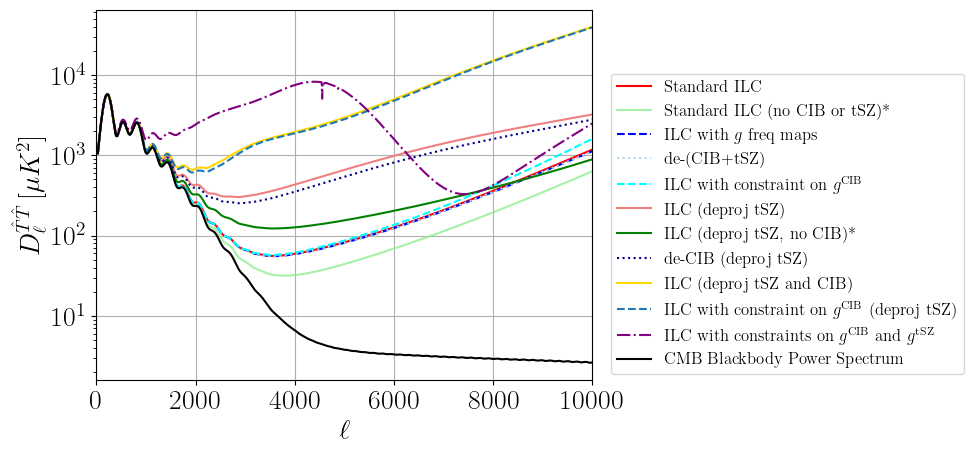

In [69]:
stop = 10000

plt.clf()
#order m5, m6, m2, m7, m9, m4, m3, m1, m8, m10
plt.plot(ells[start:stop], (ells*(ells+1)*m5.Clyy/(2*np.pi))[start:stop], label=m5_label, linestyle=m5_linestyle, color=m5_color)
plt.plot(ells[start:stop], (ells*(ells+1)*m6.Clyy/(2*np.pi))[start:stop], label=m6_label, linestyle=m6_linestyle, color=m6_color, alpha=0.8)
plt.plot(ells[start:stop], (ells*(ells+1)*m2.Clyy/(2*np.pi))[start:stop], label=m2_label, linestyle=m2_linestyle, color=m2_color)
plt.plot(ells[start:stop], (ells*(ells+1)*m7.Clyy/(2*np.pi))[start:stop], label=m7_label, linestyle=m7_linestyle, color=m7_color)
plt.plot(ells[start:stop], (ells*(ells+1)*m9.Clyy/(2*np.pi))[start:stop], label=m9_label, linestyle=m9_linestyle, color=m9_color)
plt.plot(ells[start:stop], (ells*(ells+1)*m4.Clyy/(2*np.pi))[start:stop], label=m4_label, linestyle=m4_linestyle, color=m4_color)
plt.plot(ells[start:stop], (ells*(ells+1)*m3.Clyy/(2*np.pi))[start:stop], label=m3_label, linestyle=m3_linestyle, color=m3_color)
plt.plot(ells[start:stop], (ells*(ells+1)*m1.Clyy/(2*np.pi))[start:stop], label=m1_label, linestyle=m1_linestyle, color=m1_color)
plt.plot(ells[start:stop], (ells*(ells+1)*m8.Clyy/(2*np.pi))[start:stop], label=m8_label, linestyle=m8_linestyle, color=m8_color)
plt.plot(ells[start:stop], (ells*(ells+1)*m10.Clyy/(2*np.pi))[start:stop], label=m10_label, linestyle=m10_linestyle, color=m10_color)
plt.plot(ells[start:stop], (ells*(ells+1)*m11.Clyy/(2*np.pi))[start:stop], label=m11_label, linestyle=m11_linestyle, color=m11_color)

#uncomment line below for de-CIB but using P14 CIB model to find optimal tracer coefficients
#plt.plot(ells[start:stop], (ells*(ells+1)*m1_alt.Clyy/(2*np.pi))[start:stop], label='de-CIB (deproj tSZ) using P14', linestyle='dashdot', color='blue')

#uncomment lines below for MCILC plots
# plt.plot(ells[start:stop], (ells*(ells+1)*mtest.Clyy/(2*np.pi))[start:stop], label='Deproj each g separately in ILC', linestyle='dotted', color='m')
# plt.plot(ells[start:stop], (ells*(ells+1)*mtest_deprojtSZ.Clyy/(2*np.pi))[start:stop], label='Deproj each g separately in ILC with deproj tSZ', linestyle='dotted', color='mediumpurple')

ksz_idx = spectra1.comps.index('kSZ')
cmb_idx = spectra1.comps.index('CMB')
plt.plot(ells[start:stop], (ells*(ells+1)*(spectra1.all_spectra[ksz_idx,0,ksz_idx,0]+spectra1.all_spectra[cmb_idx,0,cmb_idx,0])/(2*np.pi))[start:stop], label='CMB Blackbody Power Spectrum', linestyle='solid', color='k')
plt.xlabel(r'$\ell$', font=font)
plt.ylabel(r'$D_{\ell}^{\hat{T}\hat{T}} \, [\mu K^2]$', font=font)
plt.yscale('log')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=12,  bbox_to_anchor=(1.02, 0.85))
plt.grid()
# plt.ylim(top=10**4.5)
plt.xlim(0,10000)
plt.show()

Text(0.5, 1.0, 'H13 CIB Model with H13 Coefficients / H13 CIB Model with P14 Coefficients')

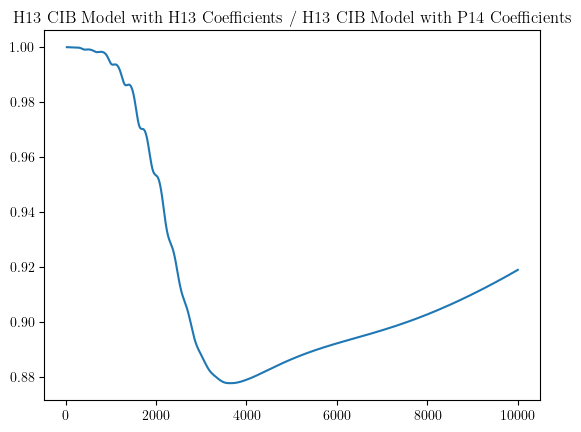

In [70]:
plt.plot(ells[start:stop], (m1.Clyy/m1_alt.Clyy)[start:stop])
plt.title('H13 CIB Model with H13 Coefficients / H13 CIB Model with P14 Coefficients')


Text(0.5, 1.0, 'ILC with g freq maps / New de-(CIB+tSZ) auto-spectrum')

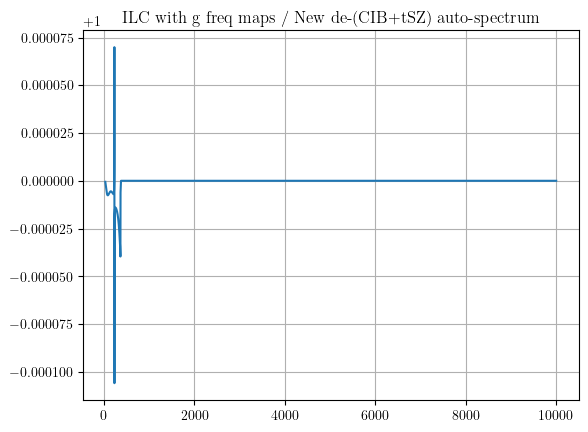

In [71]:
plt.plot(ells[start:stop], (m2.Clyy/m7.Clyy)[start:stop])
plt.grid()
plt.title('ILC with g freq maps / New de-(CIB+tSZ) auto-spectrum')

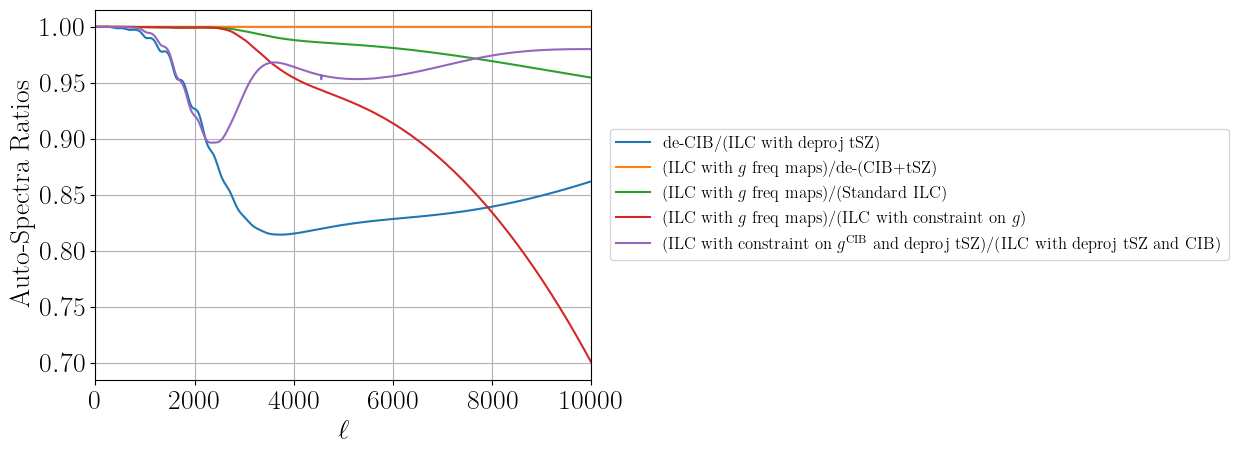

In [72]:
plt.clf()
plt.plot(ells[start:stop], (m1.Clyy/m4.Clyy)[start:stop], label='de-CIB/(ILC with deproj tSZ)')
plt.plot(ells[start:stop], (m2.Clyy/m7.Clyy)[start:stop], label=r'(ILC with $g$ freq maps)/de-(CIB+tSZ)')
plt.plot(ells[start:stop], (m2.Clyy/m5.Clyy)[start:stop], label=r'(ILC with $g$ freq maps)/(Standard ILC)')
plt.plot(ells[start:stop], (m2.Clyy/m9.Clyy)[start:stop], label=r'(ILC with $g$ freq maps)/(ILC with constraint on $g$)')
plt.plot(ells[start:stop], (m10.Clyy/m8.Clyy)[start:stop], label=r'(ILC with constraint on $g^{\mathrm{CIB}}$ and deproj tSZ)/(ILC with deproj tSZ and CIB)')

plt.xlabel(r'$\ell$', font=font)
plt.ylabel(r'Auto-Spectra Ratios', font=font)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=12,  bbox_to_anchor=(1.02, 0.7))
plt.xlim(0,10000)
plt.grid()
plt.show()

## Check Tclean correlation with galaxies (for blue, green, and red)

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/156913297.py:23: RuntimeWarning: invalid value encountered in sqrt
  ILC_g_corr_method7 = (np.einsum('il,il->l', m7.w, Clig-np.einsum('il,il,ial,al->l',m7.w,m7.f,m7.c,m7.Clgg[:,c,:]))) / np.sqrt(m7.Clyy*Clgg)
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/156913297.py:26: RuntimeWarning: invalid value encountered in divide
  ILC_g_corr_method10 = np.einsum('il,il->l', m10.w, Clig) / np.sqrt(m10.Clyy*Clgg)


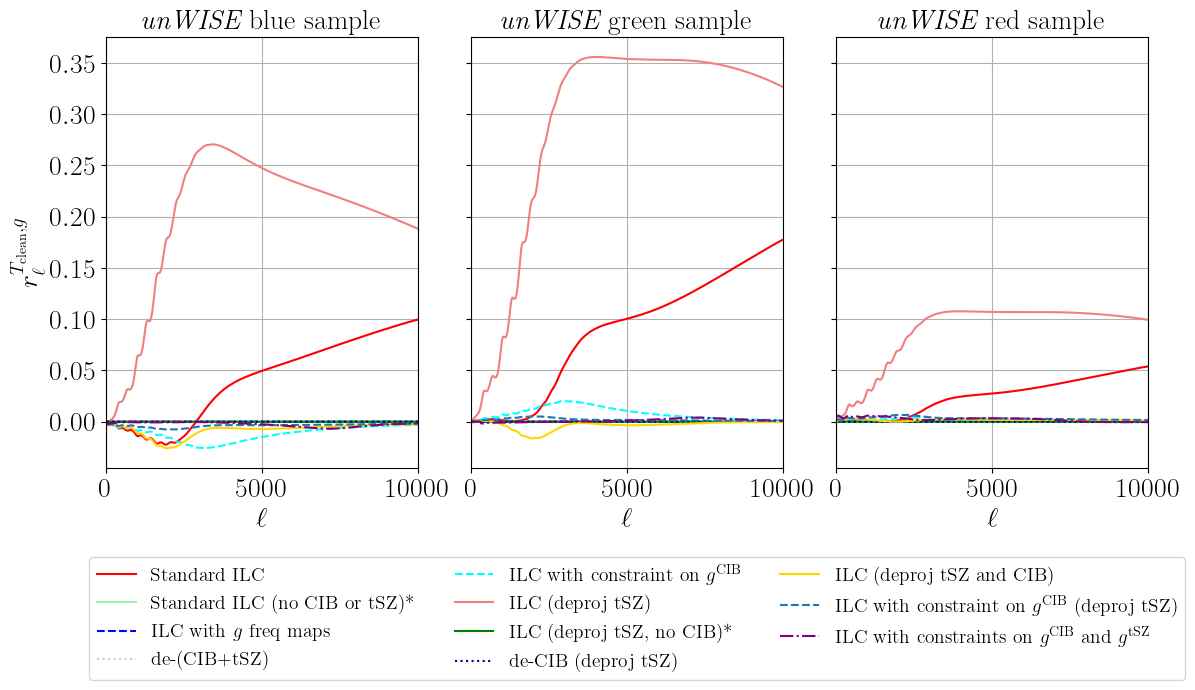

In [73]:
cib_idx = spectra1.comps.index('CIB')
tsz_idx = spectra1.comps.index('tSZ')
colors = ['blue', 'green', 'red']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6), sharey=True)
axes = [ax1, ax2, ax3]
ax = 0

for c in range(3): #blue, green, red
    color = colors[c]
    Clgg = spectra1.Clgg[c,c,:]
    Clig = spectra1.Clig[:,c,:]
    ILC_g_corr_method1 = (np.einsum('il,il->l', m1.w, Clig)-np.einsum('l,al,al->l', m1.f, m1.c, m1.Clgg[:,c,:])) / np.sqrt(m1.Clyy*Clgg)
    ILC_g_corr_method2 = np.einsum('jl,jl->l', m2.w, np.concatenate((Clig, spectra1.Clgg[:,c,:]))) / np.sqrt(m2.Clyy*Clgg)
    comp_nocib_cross_g_spectra = np.delete(np.copy(spectra1.comp_cross_g_spectra), (cib_idx), axis=0)
    comp_nocibtsz_cross_g_spectra = np.delete(np.copy(spectra1.comp_cross_g_spectra), (cib_idx, tsz_idx), axis=0)
    Clig_no_cib = np.einsum('ail->il', comp_nocib_cross_g_spectra[:,:,c,:]) #index as Clig[i][l]
    Clig_no_cibtsz = np.einsum('ail->il', comp_nocibtsz_cross_g_spectra[:,:,c,:])
    ILC_g_corr_method3 = np.einsum('il,il->l', m3.w, Clig_no_cib) / np.sqrt(m3.Clyy*Clgg)
    ILC_g_corr_method4 = np.einsum('il,il->l', m4.w, Clig) / np.sqrt(m4.Clyy*Clgg)
    ILC_g_corr_method5 = np.einsum('il,il->l', m5.w, Clig) / np.sqrt(m5.Clyy*Clgg) #use de-CIB g^i or de-(CIB+tSZ) g^i?
    ILC_g_corr_method6 = np.einsum('il,il->l', m6.w, Clig_no_cibtsz) / np.sqrt(m6.Clyy*Clgg)
    ILC_g_corr_method7 = (np.einsum('il,il->l', m7.w, Clig-np.einsum('il,il,ial,al->l',m7.w,m7.f,m7.c,m7.Clgg[:,c,:]))) / np.sqrt(m7.Clyy*Clgg)
    ILC_g_corr_method8 = np.einsum('il,il->l', m8.w, Clig) / np.sqrt(m8.Clyy*Clgg)
    ILC_g_corr_method9 = np.einsum('il,il->l', m9.w, Clig) / np.sqrt(m9.Clyy*Clgg)
    ILC_g_corr_method10 = np.einsum('il,il->l', m10.w, Clig) / np.sqrt(m10.Clyy*Clgg)
    ILC_g_corr_method11 = np.einsum('il,il->l', m11.w, Clig) / np.sqrt(m11.Clyy*Clgg)
    
    
        
    plt.axes(axes[ax])
    plt.plot(ells[start:], ILC_g_corr_method5[start:], label=m5_label, linestyle=m5_linestyle, color=m5_color)
    plt.plot(ells[start:], ILC_g_corr_method6[start:], label=m6_label, linestyle=m6_linestyle, color=m6_color, alpha=0.8)
    plt.plot(ells[start:], ILC_g_corr_method2[start:], label=m2_label, linestyle=m2_linestyle, color=m2_color)
    plt.plot(ells[start:], ILC_g_corr_method7[start:], label=m7_label, linestyle=m7_linestyle, color=m7_color)
    plt.plot(ells[start:], ILC_g_corr_method9[start:], label=m9_label, linestyle=m9_linestyle, color=m9_color)
    plt.plot(ells[start:], ILC_g_corr_method4[start:], label=m4_label, linestyle=m4_linestyle, color=m4_color)
    plt.plot(ells[start:], ILC_g_corr_method3[start:], label=m3_label, linestyle=m3_linestyle, color=m3_color)
    plt.plot(ells[start:], ILC_g_corr_method1[start:], label=m1_label, linestyle=m1_linestyle, color=m1_color)
    plt.plot(ells[start:], ILC_g_corr_method8[start:], label=m8_label, linestyle=m8_linestyle, color=m8_color)
    plt.plot(ells[start:], ILC_g_corr_method10[start:], label=m10_label, linestyle=m10_linestyle, color=m10_color)
    plt.plot(ells[start:], ILC_g_corr_method11[start:], label=m11_label, linestyle=m11_linestyle, color=m11_color)
    plt.xlabel(r'$\ell$', fontsize=20)
    if ax==0:
        plt.ylabel(r'$r_{\ell}^{T_{\rm clean},g}$ ', fontsize=20)
    ax += 1
    plt.title(r'$\emph{unWISE}$ '+f'{color} sample', fontsize=20)
    plt.grid()
    plt.xlim(0,10000)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20, ticks=[0,5000,10000])
    handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=14, bbox_to_anchor=(1.0, 0.), ncol=3)
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(top=0.85)
plt.savefig(f'{output_dir}/{prefix}_Tcleanxg.pdf', bbox_inches = "tight")
plt.show()



## View relative combinations of blue, green, red for optimal correlation with CIB + tSZ

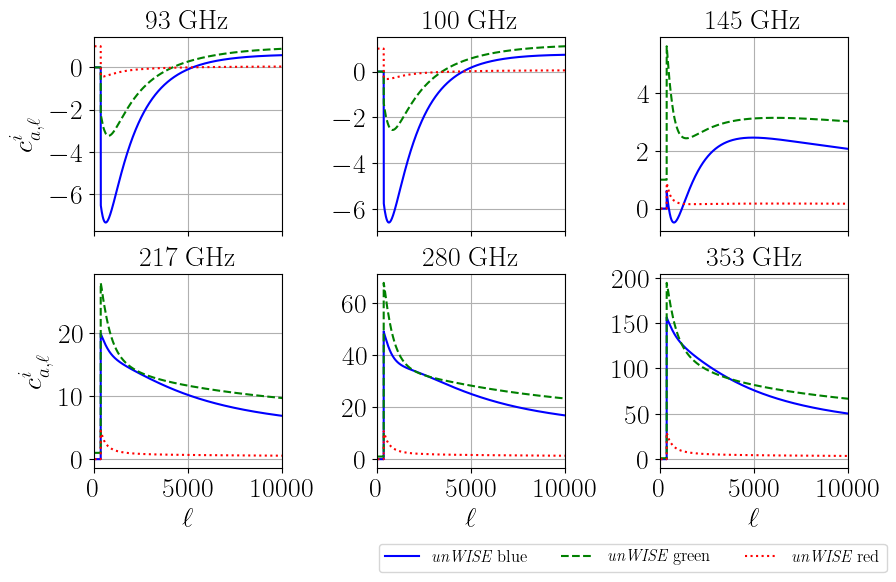

In [74]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(9,6), sharex=True)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ax = 0
for i, freq in enumerate(spectra1.freqs):
    if freq not in freqs_to_plot: continue
    plt.axes(axes[ax])
    plt.title(f'{spectra1.freqs[i]} GHz', font=font)
    plt.grid()
    for j in range(3):
        if j==0:
            color='blue'
            linestyle='solid'
        elif j==1:
            color='green'
            linestyle='dashed'
        else:
            color='red'
            linestyle='dotted'
        plt.plot(ells[start:stop], m7.c[i][j][start:stop], color=color, label=r'$\emph{unWISE}$ ' + color, linestyle=linestyle)
    if ax >= 3:
        plt.xlabel(r'$\ell$', font=font)
    if ax%3 == 0:
        plt.ylabel(r'$c^i_{a,\ell}$', font=font)
    ax += 1
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20, ticks=[0,5000,10000])
    plt.xlim(0,10000)
    handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.0, 0.02), fontsize=12, ncol=3)
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(top=0.85)
plt.savefig(f'{output_dir}/{prefix}_optimal_comb_CIBplustSZ.pdf', bbox_inches = "tight")
plt.show()

## Check correlation of Tclean and CIB

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/2115382623.py:31: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method2 = np.einsum('jl,jl->l', m2.w, np.concatenate((comp_cross_cib_spectra[i], cib_cross_g_spectrum[i]))) / np.sqrt(m2.Clyy*spectra1.all_spectra[cib_idx][i][cib_idx][i])
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/2115382623.py:32: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method3 = np.einsum('il,il->l', m3.w,Cl_inocib_cib) / np.sqrt(m3.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/2115382623.py:33: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method4 = np.einsum('il,il->l', m4.w,Cl_i_cib) / np.sqrt(m4.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/2115382623.py:34: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method5 =

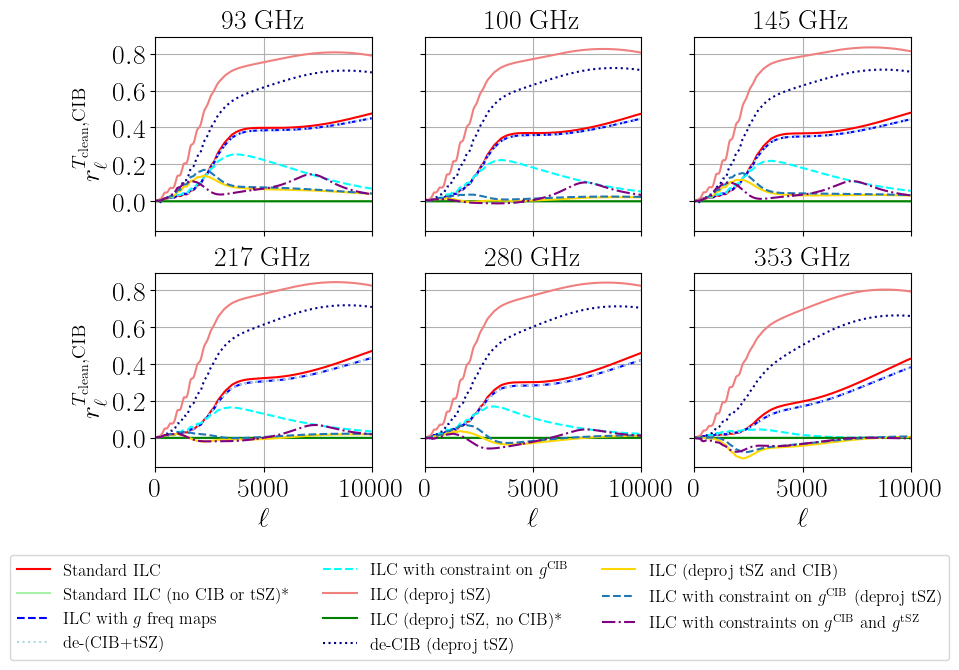

In [75]:
comp_cross_cib_spectra = np.zeros((len(spectra1.comps), len(spectra1.freqs), spectra1.ellmax+1))

cib_idx = spectra1.comps.index('CIB')
tsz_idx = spectra1.comps.index('tSZ')

#index as comp_cross_cib_spectra[i][j] for cross-spectrum of CIB_i and T_j
comp_cross_cib_spectra = np.einsum('ibjl->ijl', spectra1.all_spectra[cib_idx])

#index as cib_cross_g_spectrum[i][b] for cross-spectrum CIB_i and g_b
cib_cross_g_spectrum = spectra1.comp_cross_g_spectra[cib_idx]

#for Method 3 (ILC with no CIB or g)
compnocib_cross_cib_spectra = np.delete(np.copy(spectra1.all_spectra), (cib_idx), axis=2)
compnocib_cross_cib_spectra = np.einsum('ibjl->ijl', compnocib_cross_cib_spectra[cib_idx])
compnocibtsz_cross_cib_spectra = np.delete(np.copy(spectra1.all_spectra), (cib_idx, tsz_idx), axis=2)
compnocibtsz_cross_cib_spectra = np.einsum('ibjl->ijl', compnocibtsz_cross_cib_spectra[cib_idx])


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(9,6), sharex=True, sharey=True)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ax = 0

for i,freq1 in enumerate(spectra1.freqs):
    if freq1 not in freqs_to_plot: continue
    Cl_i_cib = comp_cross_cib_spectra[i]
    Cl_g_cib = cib_cross_g_spectrum[i]
    Cl_inocib_cib = compnocib_cross_cib_spectra[i]
    Cl_inocibtsz_cib = compnocibtsz_cross_cib_spectra[i]
    
    ILC_CIB_corr_method1 = (np.einsum('il,il->l', m1.w,Cl_i_cib) - np.einsum('l,al,al->l', m1.f,m1.c,Cl_g_cib))/ np.sqrt(m1.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method2 = np.einsum('jl,jl->l', m2.w, np.concatenate((comp_cross_cib_spectra[i], cib_cross_g_spectrum[i]))) / np.sqrt(m2.Clyy*spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method3 = np.einsum('il,il->l', m3.w,Cl_inocib_cib) / np.sqrt(m3.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method4 = np.einsum('il,il->l', m4.w,Cl_i_cib) / np.sqrt(m4.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method5 = np.einsum('il,il->l', m5.w,Cl_i_cib) / np.sqrt(m5.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method6 = np.einsum('il,il->l', m6.w,Cl_inocibtsz_cib) / np.sqrt(m6.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method7 = (np.einsum('il,il->l', m7.w,Cl_i_cib) - np.einsum('jl,jl,jal,al->l', m7.w, m7.f, m7.c, Cl_g_cib))/ np.sqrt(m7.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method8 = np.einsum('il,il->l', m8.w,Cl_i_cib) / np.sqrt(m8.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method9 = np.einsum('il,il->l', m9.w,Cl_i_cib) / np.sqrt(m9.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method10 = np.einsum('il,il->l', m10.w,Cl_i_cib) / np.sqrt(m10.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method11 = np.einsum('il,il->l', m11.w,Cl_i_cib) / np.sqrt(m11.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    
    plt.axes(axes[ax])
    plt.plot(ells[start:], ILC_CIB_corr_method5[start:], label=m5_label, linestyle=m5_linestyle, color=m5_color)
    plt.plot(ells[start:], ILC_CIB_corr_method6[start:], label=m6_label, linestyle=m6_linestyle, color=m6_color, alpha=0.8)
    plt.plot(ells[start:], ILC_CIB_corr_method2[start:], label=m2_label, linestyle=m2_linestyle, color=m2_color)
    plt.plot(ells[start:], ILC_CIB_corr_method7[start:], label=m7_label, linestyle=m7_linestyle, color=m7_color)
    plt.plot(ells[start:], ILC_CIB_corr_method9[start:], label=m9_label, linestyle=m9_linestyle, color=m9_color)
    plt.plot(ells[start:], ILC_CIB_corr_method4[start:], label=m4_label, linestyle=m4_linestyle, color=m4_color)
    plt.plot(ells[start:], ILC_CIB_corr_method3[start:], label=m3_label, linestyle=m3_linestyle, color=m3_color)
    plt.plot(ells[start:], ILC_CIB_corr_method1[start:], label=m1_label, linestyle=m1_linestyle, color=m1_color)
    plt.plot(ells[start:], ILC_CIB_corr_method8[start:], label=m8_label, linestyle=m8_linestyle, color=m8_color)
    plt.plot(ells[start:], ILC_CIB_corr_method10[start:], label=m10_label, linestyle=m10_linestyle, color=m10_color)
    plt.plot(ells[start:], ILC_CIB_corr_method11[start:], label=m11_label, linestyle=m11_linestyle, color=m11_color)

    if ax >= 3:
        plt.xlabel(r'$\ell$', fontsize=20)
    if ax%3 == 0:
        plt.ylabel(r'$r_{\ell}^{T_{\rm clean}, \rm CIB}$', fontsize=20)
    ax += 1
    plt.title(f'{freq1} GHz', fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20, ticks=[0,5000,10000])
    plt.grid()
    plt.xlim(0,10000)
    handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels,  bbox_to_anchor=(1.0, 0.), ncol=3, fontsize=12)
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(top=0.85)
plt.savefig(f'{output_dir}/{prefix}_TcleanxCIB_corr.pdf', bbox_inches = "tight")
plt.show()

## Check Tclean x CIB spectra

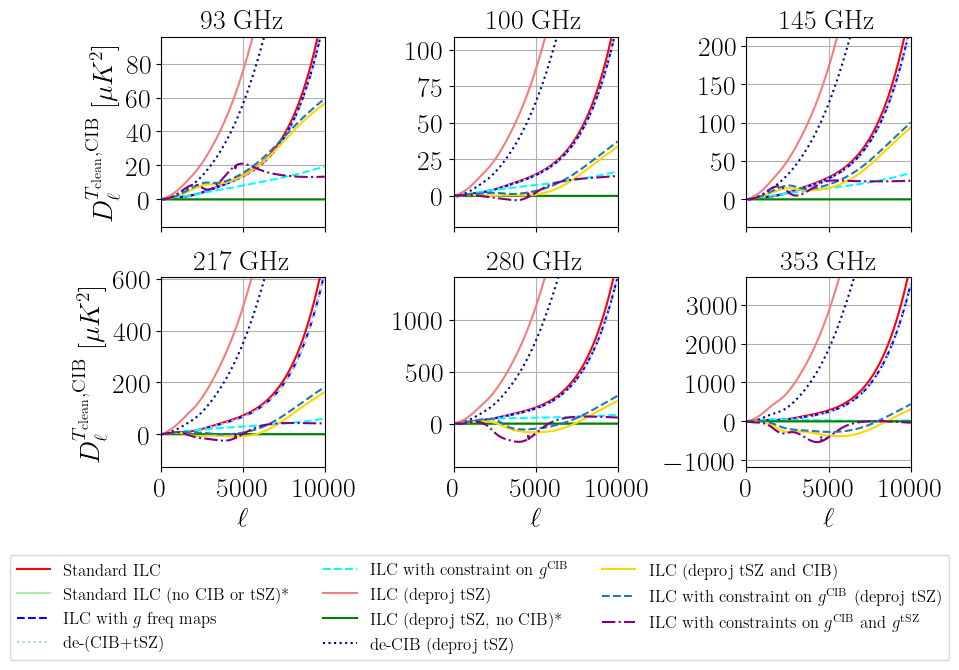

In [76]:
comp_cross_cib_spectra = np.zeros((len(spectra1.comps), len(spectra1.freqs), spectra1.ellmax+1))

cib_idx = spectra1.comps.index('CIB')
tsz_idx = spectra1.comps.index('tSZ')

#index as comp_cross_cib_spectra[i][j] for cross-spectrum of CIB_i and T_j
comp_cross_cib_spectra = np.einsum('ibjl->ijl', spectra1.all_spectra[cib_idx])

#index as cib_cross_g_spectrum[i][b] for cross-spectrum CIB_i and g_b
cib_cross_g_spectrum = spectra1.comp_cross_g_spectra[cib_idx]

#for Method 3 (ILC with no CIB or g)
compnocib_cross_cib_spectra = np.delete(np.copy(spectra1.all_spectra), (cib_idx), axis=2)
compnocib_cross_cib_spectra = np.einsum('ibjl->ijl', compnocib_cross_cib_spectra[cib_idx])
compnocibtsz_cross_cib_spectra = np.delete(np.copy(spectra1.all_spectra), (cib_idx, tsz_idx), axis=2)
compnocibtsz_cross_cib_spectra = np.einsum('ibjl->ijl', compnocibtsz_cross_cib_spectra[cib_idx])


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(9,6), sharex=True)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ax = 0

for i,freq1 in enumerate(spectra1.freqs):
    if freq1 not in freqs_to_plot: continue
    Cl_i_cib = comp_cross_cib_spectra[i]
    Cl_g_cib = cib_cross_g_spectrum[i]
    Cl_inocib_cib = compnocib_cross_cib_spectra[i]
    Cl_inocibtsz_cib = compnocibtsz_cross_cib_spectra[i]
    
    ILC_CIB_cross_method1 = (np.einsum('il,il->l', m1.w,Cl_i_cib) - np.einsum('l,al,al->l', m1.f,m1.c,Cl_g_cib))
    ILC_CIB_cross_method2 = np.einsum('jl,jl->l', m2.w, np.concatenate((comp_cross_cib_spectra[i], cib_cross_g_spectrum[i]))) 
    ILC_CIB_cross_method3 = np.einsum('il,il->l', m3.w,Cl_inocib_cib)
    ILC_CIB_cross_method4 = np.einsum('il,il->l', m4.w,Cl_i_cib)
    ILC_CIB_cross_method5 = np.einsum('il,il->l', m5.w,Cl_i_cib)
    ILC_CIB_cross_method6 = np.einsum('il,il->l', m6.w,Cl_inocibtsz_cib)
    ILC_CIB_cross_method7 = (np.einsum('il,il->l', m7.w,Cl_i_cib) - np.einsum('jl,jl,jal,al->l', m7.w, m7.f, m7.c, Cl_g_cib))
    ILC_CIB_cross_method8 = np.einsum('il,il->l', m8.w,Cl_i_cib)
    ILC_CIB_cross_method9 = np.einsum('il,il->l', m9.w,Cl_i_cib)
    ILC_CIB_cross_method10 = np.einsum('il,il->l', m10.w,Cl_i_cib)
    ILC_CIB_cross_method11 = np.einsum('il,il->l', m11.w,Cl_i_cib)
    
    
    to_dl = (ells*(ells+1)/(2*np.pi))[start:]
    plt.axes(axes[ax])
    plt.plot(ells[start:], to_dl*ILC_CIB_cross_method5[start:], label=m5_label, linestyle=m5_linestyle, color=m5_color)
    plt.plot(ells[start:], to_dl*ILC_CIB_cross_method6[start:], label=m6_label, linestyle=m6_linestyle, color=m6_color, alpha=0.8)
    plt.plot(ells[start:], to_dl*ILC_CIB_cross_method2[start:], label=m2_label, linestyle=m2_linestyle, color=m2_color)
    plt.plot(ells[start:], to_dl*ILC_CIB_cross_method7[start:], label=m7_label, linestyle=m7_linestyle, color=m7_color)
    plt.plot(ells[start:], to_dl*ILC_CIB_cross_method9[start:], label=m9_label, linestyle=m9_linestyle, color=m9_color)
    plt.plot(ells[start:], to_dl*ILC_CIB_cross_method4[start:], label=m4_label, linestyle=m4_linestyle, color=m4_color)
    plt.plot(ells[start:], to_dl*ILC_CIB_cross_method3[start:], label=m3_label, linestyle=m3_linestyle, color=m3_color)
    plt.plot(ells[start:], to_dl*ILC_CIB_cross_method1[start:], label=m1_label, linestyle=m1_linestyle, color=m1_color)
    plt.plot(ells[start:], to_dl*ILC_CIB_cross_method8[start:], label=m8_label, linestyle=m8_linestyle, color=m8_color)
    plt.plot(ells[start:], to_dl*ILC_CIB_cross_method10[start:], label=m10_label, linestyle=m10_linestyle, color=m10_color)
    plt.plot(ells[start:], to_dl*ILC_CIB_cross_method11[start:], label=m11_label, linestyle=m11_linestyle, color=m11_color)

    if ax >= 3:
        plt.xlabel(r'$\ell$', fontsize=20)
    if ax%3 == 0:
        plt.ylabel(r'$D_{\ell}^{T_{\rm clean}, \rm{CIB}}$ [$\mu K^2$]', fontsize=20)
    ax += 1
    plt.title(f'{freq1} GHz', fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20, ticks=[0,5000,10000])
    plt.grid()
    plt.xlim(0,10000)
    plt.ylim(top=np.nanmax(to_dl*ILC_CIB_cross_method4[start:])*0.3)
    handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels,  bbox_to_anchor=(1.0, 0.), ncol=3, fontsize=12)
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(top=0.85)
plt.savefig(f'{output_dir}/{prefix}_TcleanxCIB_spectra.pdf', bbox_inches = "tight")
plt.show()

## Check correlation of $(\rm CIB + \rm tSZ)^i$ with $g^i$ with $g^i$ Obtained for Max (CIB+tSZ) Correlation

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3953961459.py:6: RuntimeWarning: invalid value encountered in sqrt
  corr = np.einsum('al,al->l', m7.c[i], spectra1.comp_cross_g_spectra[cib_idx][i] + spectra1.comp_cross_g_spectra[tsz_idx][i]) / np.sqrt((spectra1.all_spectra[cib_idx][i][cib_idx][i]+spectra1.all_spectra[tsz_idx][i][tsz_idx][i]+2*spectra1.all_spectra[tsz_idx][i][cib_idx][i])*np.einsum('al,bl,abl->l', m7.c[i],m7.c[i],m7.Clgg))


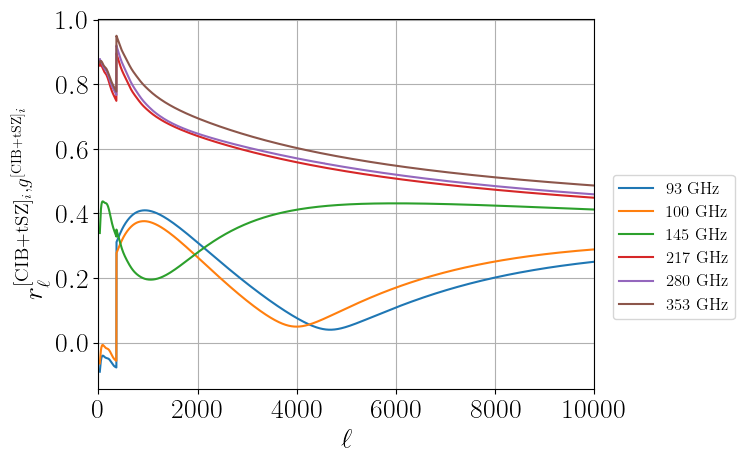

In [77]:
plt.clf()
cib_idx = spectra1.comps.index('CIB')
tsz_idx = spectra1.comps.index('tSZ')
for i, freq in enumerate(spectra1.freqs):
    if freq not in freqs_to_plot: continue
    corr = np.einsum('al,al->l', m7.c[i], spectra1.comp_cross_g_spectra[cib_idx][i] + spectra1.comp_cross_g_spectra[tsz_idx][i]) / np.sqrt((spectra1.all_spectra[cib_idx][i][cib_idx][i]+spectra1.all_spectra[tsz_idx][i][tsz_idx][i]+2*spectra1.all_spectra[tsz_idx][i][cib_idx][i])*np.einsum('al,bl,abl->l', m7.c[i],m7.c[i],m7.Clgg))
    plt.plot(ells[start:], corr[start:], label=f'{freqs[i]} GHz')
plt.xlabel(r'$\ell$', font=font)
plt.ylabel(r'$r_{\ell}^{[\mathrm{CIB}+\mathrm{tSZ}]_i, g^{[\mathrm{CIB}+\mathrm{tSZ}]_i}}$', font=font)
plt.grid()
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(0,10000)
plt.legend(fontsize=12, bbox_to_anchor=(1.3, 0.6))
plt.savefig(f'{output_dir}/{prefix}_CIBplustSZxg_CIBplustSZ.pdf', bbox_inches = "tight")
plt.show()

## Tclean x Compton-y Spectra and Correlation Coefficient

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/1224372404.py:65: RuntimeWarning: invalid value encountered in sqrt
  ILC_tsz_corr_method2 = np.einsum('jl,jl->l', m2.w, np.concatenate((comp_cross_tsz_spectra[i], tsz_cross_g_spectrum[i]))) / np.sqrt(m2.Clyy*spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/1224372404.py:65: RuntimeWarning: invalid value encountered in divide
  ILC_tsz_corr_method2 = np.einsum('jl,jl->l', m2.w, np.concatenate((comp_cross_tsz_spectra[i], tsz_cross_g_spectrum[i]))) / np.sqrt(m2.Clyy*spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/1224372404.py:66: RuntimeWarning: invalid value encountered in sqrt
  ILC_tsz_corr_method3 = np.einsum('il,il->l', m3.w,Cl_inocib_tsz) / np.sqrt(m3.Clyy * spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/1224372404.py:66: RuntimeWarnin

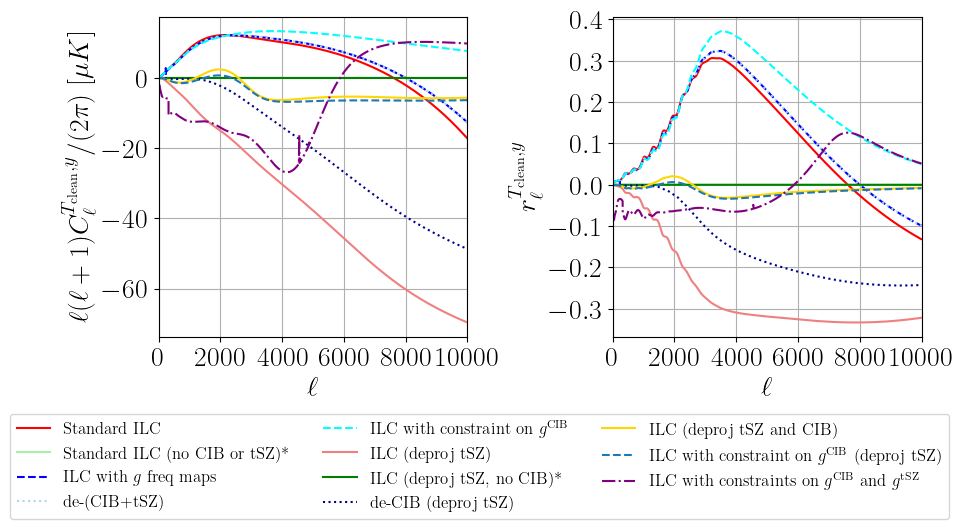

In [78]:
#corr coeff is same for all frequencies since spectral response cancels out

comp_cross_tsz_spectra = np.zeros((len(spectra1.comps), len(spectra1.freqs), spectra1.ellmax+1))

tsz_idx = spectra1.comps.index('tSZ')

#index as comp_cross_tsz_spectra[i][j] for cross-spectrum of tSZ_i and T_j
comp_cross_tsz_spectra = np.einsum('ibjl->ijl', spectra1.all_spectra[tsz_idx])

#index as tsz_cross_g_spectrum[i][b] for cross-spectrum tSZ_i and g_b
tsz_cross_g_spectrum = spectra1.comp_cross_g_spectra[tsz_idx]

#for Method 3 (ILC with no CIB or g)
compnocib_cross_tsz_spectra = np.delete(np.copy(spectra1.all_spectra), (cib_idx), axis=2)
compnocib_cross_tsz_spectra = np.einsum('ibjl->ijl', compnocib_cross_tsz_spectra[tsz_idx])
compnocibtsz_cross_tsz_spectra = np.delete(np.copy(spectra1.all_spectra), (cib_idx, tsz_idx), axis=2)
compnocibtsz_cross_tsz_spectra = np.einsum('ibjl->ijl', compnocibtsz_cross_tsz_spectra[tsz_idx])


i=0
resp = spectra1.tsz_spectral_response([spectra1.freqs[i]])
Cl_i_tsz = comp_cross_tsz_spectra[i]
Cl_g_tsz = tsz_cross_g_spectrum[i]
Cl_inocib_tsz = compnocib_cross_tsz_spectra[i]
Cl_inocibtsz_tsz = compnocibtsz_cross_tsz_spectra[i]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,4), layout='constrained')

for p in range(2):
    
    if p==0:
        plt.axes(ax1)
        ILC_tsz_cross_method1 = (np.einsum('il,il->l', m1.w,Cl_i_tsz) - np.einsum('l,al,al->l', m1.f,m1.c,tsz_cross_g_spectrum[i]))
        ILC_tsz_cross_method2 = np.einsum('jl,jl->l', m2.w, np.concatenate((comp_cross_tsz_spectra[i], tsz_cross_g_spectrum[i])))
        ILC_tsz_cross_method3 = np.einsum('il,il->l', m3.w,Cl_inocib_tsz)
        ILC_tsz_cross_method4 = np.einsum('il,il->l', m4.w,Cl_i_tsz)
        ILC_tsz_cross_method5 = np.einsum('il,il->l', m5.w,Cl_i_tsz)
        ILC_tsz_cross_method6 = np.einsum('il,il->l', m6.w,Cl_inocibtsz_tsz)
        ILC_tsz_cross_method7 = (np.einsum('il,il->l', m7.w,Cl_i_tsz) - np.einsum('jl,jl,jal,al->l', m7.w, m7.f, m7.c, tsz_cross_g_spectrum[i]))
        ILC_tsz_cross_method8 = np.einsum('il,il->l', m8.w,Cl_i_tsz)
        ILC_tsz_cross_method9 = np.einsum('il,il->l', m9.w,Cl_i_tsz) 
        ILC_tsz_cross_method10 = np.einsum('il,il->l', m10.w,Cl_i_tsz) 
        ILC_tsz_cross_method11 = np.einsum('il,il->l', m11.w,Cl_i_tsz)

        to_dl = (ells*(ells+1)/(2*np.pi))[start:]
        plt.plot(ells[start:], to_dl*ILC_tsz_cross_method5[start:], label=m5_label, linestyle=m5_linestyle, color=m5_color)
        plt.plot(ells[start:], to_dl*ILC_tsz_cross_method6[start:], label=m6_label, linestyle=m6_linestyle, color=m6_color, alpha=0.8)
        plt.plot(ells[start:], to_dl*ILC_tsz_cross_method2[start:], label=m2_label, linestyle=m2_linestyle, color=m2_color)
        plt.plot(ells[start:], to_dl*ILC_tsz_cross_method7[start:], label=m7_label, linestyle=m7_linestyle, color=m7_color)
        plt.plot(ells[start:], to_dl*ILC_tsz_cross_method9[start:], label=m9_label, linestyle=m9_linestyle, color=m9_color)
        plt.plot(ells[start:], to_dl*ILC_tsz_cross_method4[start:], label=m4_label, linestyle=m4_linestyle, color=m4_color)
        plt.plot(ells[start:], to_dl*ILC_tsz_cross_method3[start:], label=m3_label, linestyle=m3_linestyle, color=m3_color)
        plt.plot(ells[start:], to_dl*ILC_tsz_cross_method1[start:], label=m1_label, linestyle=m1_linestyle, color=m1_color)
        plt.plot(ells[start:], to_dl*ILC_tsz_cross_method8[start:], label=m8_label, linestyle=m8_linestyle, color=m8_color)
        plt.plot(ells[start:], to_dl*ILC_tsz_cross_method10[start:], label=m10_label, linestyle=m10_linestyle, color=m10_color)
        plt.plot(ells[start:], to_dl*ILC_tsz_cross_method11[start:], label=m11_label, linestyle=m11_linestyle, color=m11_color)

        plt.xlabel(r'$\ell$', fontsize=20)
        plt.ylabel(r'$\ell(\ell+1)C_\ell^{T_{\rm clean},y}/(2\pi)$ [$\mu K$]', fontsize=20)
        plt.xlim(0,10000)
   
    elif p==1:
        plt.axes(ax2)
        ILC_tsz_corr_method1 = (np.einsum('il,il->l', m1.w,Cl_i_tsz) - np.einsum('l,al,al->l', m1.f,m1.c,tsz_cross_g_spectrum[i]))/ np.sqrt(m1.Clyy * spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
        ILC_tsz_corr_method2 = np.einsum('jl,jl->l', m2.w, np.concatenate((comp_cross_tsz_spectra[i], tsz_cross_g_spectrum[i]))) / np.sqrt(m2.Clyy*spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
        ILC_tsz_corr_method3 = np.einsum('il,il->l', m3.w,Cl_inocib_tsz) / np.sqrt(m3.Clyy * spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
        ILC_tsz_corr_method4 = np.einsum('il,il->l', m4.w,Cl_i_tsz) / np.sqrt(m4.Clyy * spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
        ILC_tsz_corr_method5 = np.einsum('il,il->l', m5.w,Cl_i_tsz) / np.sqrt(m5.Clyy * spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
        ILC_tsz_corr_method6 = np.einsum('il,il->l', m6.w,Cl_inocibtsz_tsz) / np.sqrt(m6.Clyy * spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
        ILC_tsz_corr_method7 = (np.einsum('il,il->l', m7.w,Cl_i_tsz) - np.einsum('jl,jl,jal,al->l', m7.w, m7.f, m7.c, tsz_cross_g_spectrum[i])) / np.sqrt(m7.Clyy * spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
        ILC_tsz_corr_method8 = np.einsum('il,il->l', m8.w,Cl_i_tsz) / np.sqrt(m8.Clyy * spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
        ILC_tsz_corr_method9 = np.einsum('il,il->l', m9.w,Cl_i_tsz) / np.sqrt(m9.Clyy * spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
        ILC_tsz_corr_method10 = np.einsum('il,il->l', m10.w,Cl_i_tsz) / np.sqrt(m10.Clyy * spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
        ILC_tsz_corr_method11 = np.einsum('il,il->l', m11.w,Cl_i_tsz) / np.sqrt(m11.Clyy * spectra1.all_spectra[tsz_idx][i][tsz_idx][i])

        plt.plot(ells[start:], ILC_tsz_corr_method5[start:], label=m5_label, linestyle=m5_linestyle, color=m5_color)
        plt.plot(ells[start:], ILC_tsz_corr_method6[start:], label=m6_label, linestyle=m6_linestyle, color=m6_color, alpha=0.8)
        plt.plot(ells[start:], ILC_tsz_corr_method2[start:], label=m2_label, linestyle=m2_linestyle, color=m2_color)
        plt.plot(ells[start:], ILC_tsz_corr_method7[start:], label=m7_label, linestyle=m7_linestyle, color=m7_color)
        plt.plot(ells[start:], ILC_tsz_corr_method9[start:], label=m9_label, linestyle=m9_linestyle, color=m9_color)
        plt.plot(ells[start:], ILC_tsz_corr_method4[start:], label=m4_label, linestyle=m4_linestyle, color=m4_color)
        plt.plot(ells[start:], ILC_tsz_corr_method3[start:], label=m3_label, linestyle=m3_linestyle, color=m3_color)
        plt.plot(ells[start:], ILC_tsz_corr_method1[start:], label=m1_label, linestyle=m1_linestyle, color=m1_color)
        plt.plot(ells[start:], ILC_tsz_corr_method8[start:], label=m8_label, linestyle=m8_linestyle, color=m8_color)
        plt.plot(ells[start:], ILC_tsz_corr_method10[start:], label=m10_label, linestyle=m10_linestyle, color=m10_color)
        plt.plot(ells[start:], ILC_tsz_corr_method11[start:], label=m11_label, linestyle=m11_linestyle, color=m11_color)

        plt.xlabel(r'$\ell$', fontsize=20)
        plt.ylabel(r'$r_{\ell}^{T_{\rm clean}, y}$', fontsize=20)
        plt.xlim(0,10000)
    
    plt.grid()
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    handles, labels = ax1.get_legend_handles_labels()

fig.legend(handles, labels, bbox_to_anchor=(1.0, 0.), fontsize=12, ncol=3)
# plt.tight_layout()
fig = plt.gcf()
plt.savefig(f'{output_dir}/{prefix}_TcleanxtSZ.pdf', bbox_inches = "tight")
plt.show()

## Noise vs. CIB Correlation Tradeoff

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/862549680.py:30: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method2 = np.einsum('jl,jl->l', m2.w, np.concatenate((comp_cross_cib_spectra[i], cib_cross_g_spectrum[i]))) / np.sqrt(m2.Clyy*spectra1.all_spectra[cib_idx][i][cib_idx][i])
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/862549680.py:31: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method3 = np.einsum('il,il->l', m3.w,Cl_inocib_cib) / np.sqrt(m3.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/862549680.py:32: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method4 = np.einsum('il,il->l', m4.w,Cl_i_cib) / np.sqrt(m4.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/862549680.py:33: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method5 = np.

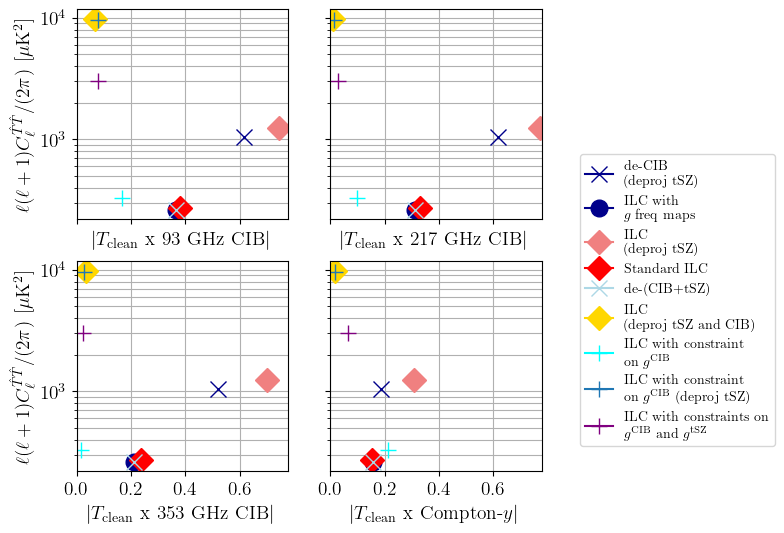

In [79]:
labels = [m1_label, m2_label, m3_label, m4_label, m5_label, m6_label, m7_label, m8_label, m9_label, m10_label, m11_label]
colors = ['darkblue', 'darkblue', 'g', 'lightcoral', 'red', 'lightgreen', 'lightblue', 'gold', 'cyan', '#1f77b4', 'purple']
markers = ['x', 'o', 'o', 'D', 'D', 'o', 'x', 'D', '+', '+', '+']
methods = [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11]
new_labels = ['de-CIB\n(deproj tSZ)', 'ILC with\n' + r'$g$ freq maps', 'ILC (deproj tSZ, no CIB)*',
             'ILC\n(deproj tSZ)', 'Standard ILC', 'Standard ILC (no CIB or tSZ)*',
             'de-(CIB+tSZ)', 'ILC\n(deproj tSZ and CIB)', 'ILC with constraint\n' + r'on $g^{\mathrm{CIB}}$',
             'ILC with constraint\n' + r'on $g^{\mathrm{CIB}}$ (deproj tSZ)', 'ILC with constraints on\n' + r'$g^{\mathrm{CIB}}$ and $g^{\mathrm{tSZ}}$']


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6,6), sharex=True, sharey=True)
axes = [ax1, ax2, ax3, ax4]
ax = 0
freqs_to_plot_here = [93, 217,353]

for j in range(len(spectra1.freqs)+1):
    if j != len(spectra1.freqs) and spectra1.freqs[j] not in freqs_to_plot_here: continue
    plt.axes(axes[ax])
    
    
    if j < len(spectra1.freqs):
        i = j
        Cl_i_cib = comp_cross_cib_spectra[i]
        Cl_g_cib = cib_cross_g_spectrum[i]
        Cl_inocib_cib = compnocib_cross_cib_spectra[i]
        Cl_inocibtsz_cib = compnocibtsz_cross_cib_spectra[i]
        xlabel = r'$|T_{\rm clean}$ x ' + str(spectra1.freqs[i]) +  r' GHz CIB$|$'
             
        ILC_CIB_corr_method1 = (np.einsum('il,il->l', m1.w,Cl_i_cib) - np.einsum('l,al,al->l', m1.f,m1.c,Cl_g_cib))/ np.sqrt(m1.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
        ILC_CIB_corr_method2 = np.einsum('jl,jl->l', m2.w, np.concatenate((comp_cross_cib_spectra[i], cib_cross_g_spectrum[i]))) / np.sqrt(m2.Clyy*spectra1.all_spectra[cib_idx][i][cib_idx][i])
        ILC_CIB_corr_method3 = np.einsum('il,il->l', m3.w,Cl_inocib_cib) / np.sqrt(m3.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
        ILC_CIB_corr_method4 = np.einsum('il,il->l', m4.w,Cl_i_cib) / np.sqrt(m4.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
        ILC_CIB_corr_method5 = np.einsum('il,il->l', m5.w,Cl_i_cib) / np.sqrt(m5.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
        ILC_CIB_corr_method6 = np.einsum('il,il->l', m6.w,Cl_inocibtsz_cib) / np.sqrt(m6.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
        ILC_CIB_corr_method7 = (np.einsum('il,il->l', m7.w,Cl_i_cib) - np.einsum('jl,jl,jal,al->l', m7.w, m7.f, m7.c, Cl_g_cib))/ np.sqrt(m7.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
        ILC_CIB_corr_method8 = np.einsum('il,il->l', m8.w,Cl_i_cib) / np.sqrt(m8.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
        ILC_CIB_corr_method9 = np.einsum('il,il->l', m9.w,Cl_i_cib) / np.sqrt(m9.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
        ILC_CIB_corr_method10 = np.einsum('il,il->l', m10.w,Cl_i_cib) / np.sqrt(m10.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
        ILC_CIB_corr_method11 = np.einsum('il,il->l', m11.w,Cl_i_cib) / np.sqrt(m11.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
        
        corrs = [ILC_CIB_corr_method1, ILC_CIB_corr_method2, ILC_CIB_corr_method3, ILC_CIB_corr_method4, ILC_CIB_corr_method5,
        ILC_CIB_corr_method6, ILC_CIB_corr_method7, ILC_CIB_corr_method8, ILC_CIB_corr_method9, ILC_CIB_corr_method10,
        ILC_CIB_corr_method11]
    
    else: #this will really be Compton-y but just name variable CIB for simplicity
        corrs = [ILC_tsz_corr_method1, ILC_tsz_corr_method2, ILC_tsz_corr_method3, ILC_tsz_corr_method4, ILC_tsz_corr_method5,
        ILC_tsz_corr_method6, ILC_tsz_corr_method7, ILC_tsz_corr_method8, ILC_tsz_corr_method9, ILC_tsz_corr_method10,
        ILC_tsz_corr_method11]
        xlabel = r'$|T_{\rm clean}$ x Compton-$y|$'
        
     
    
    xpoints = []
    ypoints = []
    for m, method in enumerate(methods):
        ILC_corr = corrs[m]
        ells_here = np.arange(2000,10000)
        xpoints.append(np.mean(abs(ILC_corr[2000:10000])))
        ypoints.append(np.mean(abs(ells_here*(ells_here+1)/2/np.pi*method.Clyy[2000:10000])))
        
    do_not_include = {2, 5}
    for i in range(len(xpoints)):
        if i not in do_not_include:
            plt.plot(xpoints[i], ypoints[i], color=colors[i], label=new_labels[i], marker=markers[i], markersize=12)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    if ax %2 == 0:
        plt.ylabel(r'$\ell(\ell+1)C_\ell^{\hat{T}\hat{T}}/(2\pi)$ [$\mu \mathrm{K}^2$]', fontsize=14)
    plt.grid(which='both')
    plt.xlim(left=0.0)
    plt.yscale('log')
    
    ax += 1
    
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(1.3, 0.65))

plt.savefig(f'{output_dir}/{prefix}_tradeoff.pdf', bbox_inches = "tight")
    
    
    
    

## Plot Noise Curves

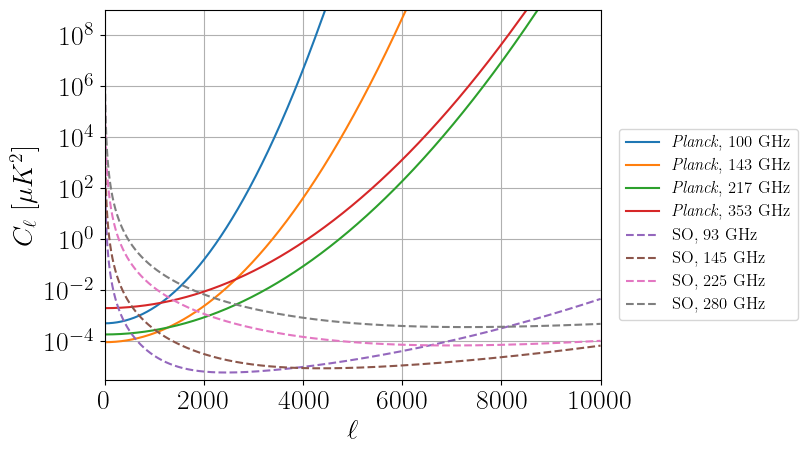

In [80]:
noise_idx = spectra1.comps.index('noise')
planck_freqs = [100, 143, 217, 353, 545]
SO_freqs = [93, 145, 225, 280]
start_noise = 2
stop = 10000

#plot Planck noise
for freq in planck_freqs:
    if freq in spectra1.freqs:
        i = spectra1.freqs.index(freq)
        noise = spectra1.all_spectra[noise_idx][i][noise_idx][i]
        plt.plot(np.arange(len(noise))[start_noise:stop], noise[start_noise:stop], label=r'$\emph{Planck}$' + f', {freq} GHz', linestyle='solid')

#Plot SO noise
for freq in SO_freqs:
    if freq in spectra1.freqs:
        i = spectra1.freqs.index(freq)
        noise = spectra1.all_spectra[noise_idx][i][noise_idx][i]
        plt.plot(np.arange(len(noise))[start_noise:stop], noise[start_noise:stop], label=f'SO, {freq} GHz', linestyle='dashed')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=20)
plt.ylabel(r'$C_{\ell}$ [$\mu K^2$]', fontsize=20)
plt.grid()
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=12, bbox_to_anchor=(1.02, 0.7))
plt.ylim(10**(-5.5), 10**(9))
plt.xlim(0,10000)
plt.savefig(f'{output_dir}/noise_curves.pdf', bbox_inches = "tight")
plt.show()
    

# Additional Plots for Paper

## Tclean auto-spectra for HerMES vs. Planck CIB Models, current and future surveys

In [81]:
spectrah = spectra('ilc-moto-2-23_hermes', ellmax, freqs, comps, gg_shot_noise, CIB_model='H13', noise=None)
spectrah.get_cls(plot=False)

m1h = de_CIB(spectrah, deltal)
m1h.auto_spectrum(plot=False)

m2h = g_freq_maps(spectrah, deltal)
m2h.ILC_auto_spectrum(plot=False)

m3h = ILC_no_CIB_no_g(spectrah, deltal)
m3h.ILC_auto_spectrum(plot=False)

m4h = ILC_no_g(spectrah, deltal)
m4h.ILC_auto_spectrum(plot=False)

m5h = standard_ILC(spectrah, deltal)
m5h.ILC_auto_spectrum(plot=False)

m6h = standard_ILC_noCIB_notSZ(spectrah, deltal)
m6h.ILC_auto_spectrum(plot=False)

m7h = de_CIBplustSZ(spectrah, deltal)
m7h.auto_spectrum(plot=False)

m8h = ILC_deproj_tSZ_and_CIB(spectrah, deltal)
m8h.ILC_auto_spectrum(plot=False)

m9h = ExplicitDeprojg_CIB(spectrah, deltal)
m9h_ILC_auto = m9h.ILC_auto_spectrum(plot=False)

m10h = ExplicitDeprojg_withtSZdeproj(spectrah, deltal)
m10h_ILC_auto = m10h.ILC_auto_spectrum(plot=False)

m11h = ExplicitDeprojg_CIBandtSZ(spectrah, deltal)
m11h_ILC_auto = m11h.ILC_auto_spectrum(plot=False)



spectrap = spectra('ilc-moto-2-23_planck', ellmax, freqs, comps, gg_shot_noise, CIB_model='P14', noise=None)
spectrap.get_cls(plot=False)

m1p = de_CIB(spectrap, deltal)
m1p.auto_spectrum(plot=False)

m2p = g_freq_maps(spectrap, deltal)
m2p.ILC_auto_spectrum(plot=False)

m3p = ILC_no_CIB_no_g(spectrap, deltal)
m3p.ILC_auto_spectrum(plot=False)

m4p = ILC_no_g(spectrap, deltal)
m4p.ILC_auto_spectrum(plot=False)

m5p = standard_ILC(spectrap, deltal)
m5p.ILC_auto_spectrum(plot=False)

m6p = standard_ILC_noCIB_notSZ(spectrap, deltal)
m6p.ILC_auto_spectrum(plot=False)

m7p = de_CIBplustSZ(spectrap, deltal)
m7p.auto_spectrum(plot=False)

m8p = ILC_deproj_tSZ_and_CIB(spectrap, deltal)
m8p.ILC_auto_spectrum(plot=False)

m9p = ExplicitDeprojg_CIB(spectrap, deltal)
m9p_ILC_auto = m9p.ILC_auto_spectrum(plot=False)

m10p = ExplicitDeprojg_withtSZdeproj(spectrap, deltal)
m10p_ILC_auto = m10p.ILC_auto_spectrum(plot=False)

m11p = ExplicitDeprojg_CIBandtSZ(spectrap, deltal)
m11p_ILC_auto = m11p.ILC_auto_spectrum(plot=False)


/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:234: RuntimeWarning: invalid value encountered in divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:234: RuntimeWarning: divide by zero encountered in divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:75: RuntimeWarning: divide by zero encountered in divide
  ksz = ksz/((self.ells)*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:261: RuntimeWarning: divide by zero encountered in divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:298: RuntimeWarning: divide by zero encountered in divide
  self.gg_spectrum[a][b] = gg/(self.ells*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trl

<Figure size 640x480 with 0 Axes>

In [82]:
gg_shot_noise_lower = gg_shot_noise/3

spectrahf = spectra('ilc-moto-2-23_hermes', ellmax, freqs, comps, gg_shot_noise_lower, CIB_model='H13', noise=None)
spectrahf.get_cls(plot=False)

m1hf = de_CIB(spectrahf, deltal)
m1hf.auto_spectrum(plot=False)

m2hf = g_freq_maps(spectrahf, deltal)
m2hf.ILC_auto_spectrum(plot=False)

m3hf = ILC_no_CIB_no_g(spectrahf, deltal)
m3hf.ILC_auto_spectrum(plot=False)

m4hf = ILC_no_g(spectrahf, deltal)
m4hf.ILC_auto_spectrum(plot=False)

m5hf = standard_ILC(spectrahf, deltal)
m5hf.ILC_auto_spectrum(plot=False)

m6hf = standard_ILC_noCIB_notSZ(spectrahf, deltal)
m6hf.ILC_auto_spectrum(plot=False)

m7hf = de_CIBplustSZ(spectrahf, deltal)
m7hf.auto_spectrum(plot=False)

m8hf = ILC_deproj_tSZ_and_CIB(spectrahf, deltal)
m8hf.ILC_auto_spectrum(plot=False)

m9hf = ExplicitDeprojg_CIB(spectrahf, deltal)
m9hf_ILC_auto = m9hf.ILC_auto_spectrum(plot=False)

m10hf = ExplicitDeprojg_withtSZdeproj(spectrahf, deltal)
m10hf_ILC_auto = m10hf.ILC_auto_spectrum(plot=False)

m11hf = ExplicitDeprojg_CIBandtSZ(spectrahf, deltal)
m11hf_ILC_auto = m11hf.ILC_auto_spectrum(plot=False)



spectrapf = spectra('ilc-moto-2-23_planck', ellmax, freqs, comps, gg_shot_noise_lower, CIB_model='P14', noise=None)
spectrapf.get_cls(plot=False)

m1pf = de_CIB(spectrapf, deltal)
m1pf.auto_spectrum(plot=False)

m2pf = g_freq_maps(spectrapf, deltal)
m2pf.ILC_auto_spectrum(plot=False)

m3pf = ILC_no_CIB_no_g(spectrapf, deltal)
m3pf.ILC_auto_spectrum(plot=False)

m4pf = ILC_no_g(spectrapf, deltal)
m4pf.ILC_auto_spectrum(plot=False)

m5pf = standard_ILC(spectrapf, deltal)
m5pf.ILC_auto_spectrum(plot=False)

m6pf = standard_ILC_noCIB_notSZ(spectrapf, deltal)
m6pf.ILC_auto_spectrum(plot=False)

m7pf = de_CIBplustSZ(spectrapf, deltal)
m7pf.auto_spectrum(plot=False)

m8pf = ILC_deproj_tSZ_and_CIB(spectrapf, deltal)
m8pf.ILC_auto_spectrum(plot=False)

m9pf = ExplicitDeprojg_CIB(spectrapf, deltal)
m9pf_ILC_auto = m9pf.ILC_auto_spectrum(plot=False)

m10pf = ExplicitDeprojg_withtSZdeproj(spectrapf, deltal)
m10pf_ILC_auto = m10pf.ILC_auto_spectrum(plot=False)

m11pf = ExplicitDeprojg_CIBandtSZ(spectrapf, deltal)
m11pf_ILC_auto = m11pf.ILC_auto_spectrum(plot=False)


/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:234: RuntimeWarning: invalid value encountered in divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:234: RuntimeWarning: divide by zero encountered in divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:75: RuntimeWarning: divide by zero encountered in divide
  ksz = ksz/((self.ells)*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:261: RuntimeWarning: divide by zero encountered in divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3695123895.py:298: RuntimeWarning: divide by zero encountered in divide
  self.gg_spectrum[a][b] = gg/(self.ells*(self.ells+1))*(2*np.pi)
/var/folders/4_/lnhhfcnn48583trl

<Figure size 640x480 with 0 Axes>

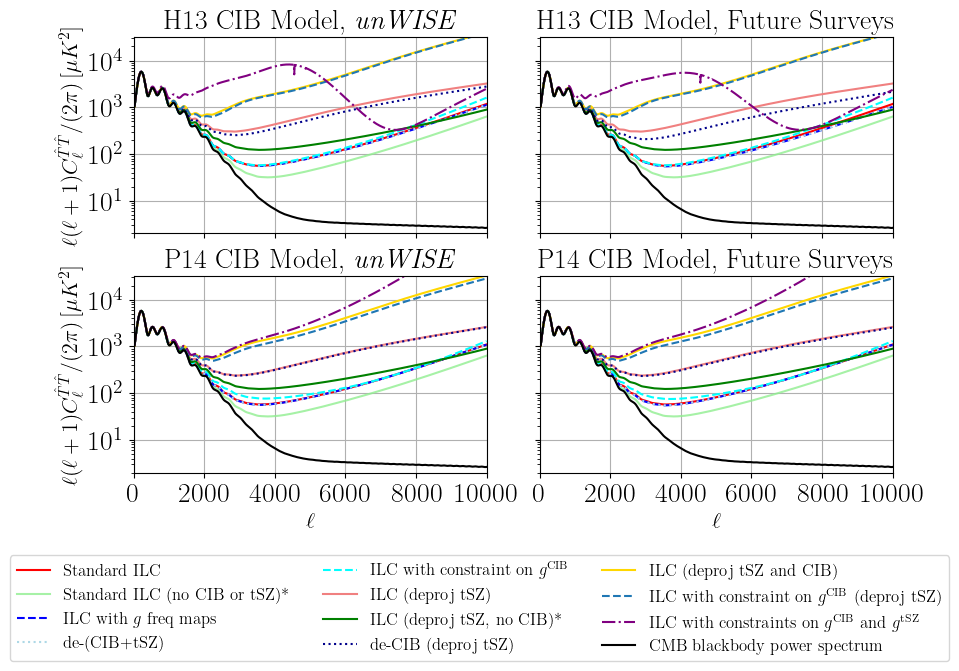

In [83]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(9,6), sharey=True, sharex=True)
ksz_idx = spectra1.comps.index('kSZ')
cmb_idx = spectra1.comps.index('CMB')

for p in range(4):
    
    if p==0:
        plt.axes(ax1)
        plt.plot(ells[start:stop], (ells*(ells+1)*m5h.Clyy/(2*np.pi))[start:stop], label=m5_label, linestyle=m5_linestyle, color=m5_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m6h.Clyy/(2*np.pi))[start:stop], label=m6_label, linestyle=m6_linestyle, color=m6_color, alpha=0.8)
        plt.plot(ells[start:stop], (ells*(ells+1)*m2h.Clyy/(2*np.pi))[start:stop], label=m2_label, linestyle=m2_linestyle, color=m2_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m7h.Clyy/(2*np.pi))[start:stop], label=m7_label, linestyle=m7_linestyle, color=m7_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m9h.Clyy/(2*np.pi))[start:stop], label=m9_label, linestyle=m9_linestyle, color=m9_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m4h.Clyy/(2*np.pi))[start:stop], label=m4_label, linestyle=m4_linestyle, color=m4_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m3h.Clyy/(2*np.pi))[start:stop], label=m3_label, linestyle=m3_linestyle, color=m3_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m1h.Clyy/(2*np.pi))[start:stop], label=m1_label, linestyle=m1_linestyle, color=m1_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m8h.Clyy/(2*np.pi))[start:stop], label=m8_label, linestyle=m8_linestyle, color=m8_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m10h.Clyy/(2*np.pi))[start:stop], label=m10_label, linestyle=m10_linestyle, color=m10_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m11h.Clyy/(2*np.pi))[start:stop], label=m11_label, linestyle=m11_linestyle, color=m11_color)
        ksz = spectra1.all_spectra[ksz_idx,0,ksz_idx,0]
        cmb = spectra1.all_spectra[cmb_idx,0,cmb_idx,0]
        plt.plot(ells[start:stop], (ells*(ells+1)*(ksz+cmb)/(2*np.pi))[start:stop], label='CMB blackbody power spectrum', linestyle='solid', color='k')
        plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{\hat{T}\hat{T}}/(2\pi) \, [\mu K^2]$', fontsize=16)
        plt.yscale('log')
        plt.title(r'H13 CIB Model, $\emph{unWISE}$', fontsize=20)
        plt.ylim(top=10**4.5, bottom=2.)
        plt.xlim(0,10000)
        
    elif p==1:
        plt.axes(ax2)
        plt.plot(ells[start:stop], (ells*(ells+1)*m5hf.Clyy/(2*np.pi))[start:stop], label=m5_label, linestyle=m5_linestyle, color=m5_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m6hf.Clyy/(2*np.pi))[start:stop], label=m6_label, linestyle=m6_linestyle, color=m6_color, alpha=0.8)
        plt.plot(ells[start:stop], (ells*(ells+1)*m2hf.Clyy/(2*np.pi))[start:stop], label=m2_label, linestyle=m2_linestyle, color=m2_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m7hf.Clyy/(2*np.pi))[start:stop], label=m7_label, linestyle=m7_linestyle, color=m7_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m9hf.Clyy/(2*np.pi))[start:stop], label=m9_label, linestyle=m9_linestyle, color=m9_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m4hf.Clyy/(2*np.pi))[start:stop], label=m4_label, linestyle=m4_linestyle, color=m4_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m3hf.Clyy/(2*np.pi))[start:stop], label=m3_label, linestyle=m3_linestyle, color=m3_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m1hf.Clyy/(2*np.pi))[start:stop], label=m1_label, linestyle=m1_linestyle, color=m1_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m8hf.Clyy/(2*np.pi))[start:stop], label=m8_label, linestyle=m8_linestyle, color=m8_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m10hf.Clyy/(2*np.pi))[start:stop], label=m10_label, linestyle=m10_linestyle, color=m10_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m11hf.Clyy/(2*np.pi))[start:stop], label=m11_label, linestyle=m11_linestyle, color=m11_color)
        ksz = spectra1.all_spectra[ksz_idx,0,ksz_idx,0]
        cmb = spectra1.all_spectra[cmb_idx,0,cmb_idx,0]
        plt.plot(ells[start:stop], (ells*(ells+1)*(ksz+cmb)/(2*np.pi))[start:stop], label='CMB blackbody power spectrum', linestyle='solid', color='k')
        plt.yscale('log')
        plt.title('H13 CIB Model, Future Surveys', fontsize=20)
        plt.ylim(top=10**4.5, bottom=2.)
        plt.xlim(0,10000)
    
    
    elif p==2:
        plt.axes(ax3)
        plt.plot(ells[start:stop], (ells*(ells+1)*m5p.Clyy/(2*np.pi))[start:stop], label=m5_label, linestyle=m5_linestyle, color=m5_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m6p.Clyy/(2*np.pi))[start:stop], label=m6_label, linestyle=m6_linestyle, color=m6_color, alpha=0.8)
        plt.plot(ells[start:stop], (ells*(ells+1)*m2p.Clyy/(2*np.pi))[start:stop], label=m2_label, linestyle=m2_linestyle, color=m2_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m7p.Clyy/(2*np.pi))[start:stop], label=m7_label, linestyle=m7_linestyle, color=m7_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m9p.Clyy/(2*np.pi))[start:stop], label=m9_label, linestyle=m9_linestyle, color=m9_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m4p.Clyy/(2*np.pi))[start:stop], label=m4_label, linestyle=m4_linestyle, color=m4_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m3p.Clyy/(2*np.pi))[start:stop], label=m3_label, linestyle=m3_linestyle, color=m3_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m1p.Clyy/(2*np.pi))[start:stop], label=m1_label, linestyle=m1_linestyle, color=m1_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m8p.Clyy/(2*np.pi))[start:stop], label=m8_label, linestyle=m8_linestyle, color=m8_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m10p.Clyy/(2*np.pi))[start:stop], label=m10_label, linestyle=m10_linestyle, color=m10_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m11p.Clyy/(2*np.pi))[start:stop], label=m11_label, linestyle=m11_linestyle, color=m11_color)
        ksz = spectra1.all_spectra[ksz_idx,0,ksz_idx,0]
        cmb = spectra1.all_spectra[cmb_idx,0,cmb_idx,0]
        plt.plot(ells[start:stop], (ells*(ells+1)*(ksz+cmb)/(2*np.pi))[start:stop], label='CMB blackbody power spectrum', linestyle='solid', color='k')
        plt.xlabel(r'$\ell$', fontsize=16)
        plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{\hat{T}\hat{T}}/(2\pi) \, [\mu K^2]$', fontsize=16)
        plt.yscale('log')
        plt.title(r'P14 CIB Model, $\emph{unWISE}$', fontsize=20)
        plt.ylim(top=10**4.5, bottom=2.)
        plt.xlim(0,10000)
    
    elif p==3:
        plt.axes(ax4)
        plt.plot(ells[start:stop], (ells*(ells+1)*m5pf.Clyy/(2*np.pi))[start:stop], label=m5_label, linestyle=m5_linestyle, color=m5_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m6pf.Clyy/(2*np.pi))[start:stop], label=m6_label, linestyle=m6_linestyle, color=m6_color, alpha=0.8)
        plt.plot(ells[start:stop], (ells*(ells+1)*m2pf.Clyy/(2*np.pi))[start:stop], label=m2_label, linestyle=m2_linestyle, color=m2_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m7pf.Clyy/(2*np.pi))[start:stop], label=m7_label, linestyle=m7_linestyle, color=m7_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m9pf.Clyy/(2*np.pi))[start:stop], label=m9_label, linestyle=m9_linestyle, color=m9_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m4pf.Clyy/(2*np.pi))[start:stop], label=m4_label, linestyle=m4_linestyle, color=m4_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m3pf.Clyy/(2*np.pi))[start:stop], label=m3_label, linestyle=m3_linestyle, color=m3_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m1pf.Clyy/(2*np.pi))[start:stop], label=m1_label, linestyle=m1_linestyle, color=m1_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m8pf.Clyy/(2*np.pi))[start:stop], label=m8_label, linestyle=m8_linestyle, color=m8_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m10pf.Clyy/(2*np.pi))[start:stop], label=m10_label, linestyle=m10_linestyle, color=m10_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m11pf.Clyy/(2*np.pi))[start:stop], label=m11_label, linestyle=m11_linestyle, color=m11_color)
        ksz = spectra1.all_spectra[ksz_idx,0,ksz_idx,0]
        cmb = spectra1.all_spectra[cmb_idx,0,cmb_idx,0]
        plt.plot(ells[start:stop], (ells*(ells+1)*(ksz+cmb)/(2*np.pi))[start:stop], label='CMB blackbody power spectrum', linestyle='solid', color='k')
        plt.xlabel(r'$\ell$', fontsize=16)
        plt.yscale('log')
        plt.title('P14 CIB Model, Future Surveys', fontsize=20)
        plt.ylim(top=10**4.5, bottom=2.)
        plt.xlim(0,10000)
    
    plt.grid()
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    handles, labels = ax1.get_legend_handles_labels()

fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.), fontsize=12, ncol=3)
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(top=0.85)
plt.savefig(f'{output_dir}/Tclean_auto_spectra.pdf', bbox_inches = "tight")
plt.show()
    
    
        
        

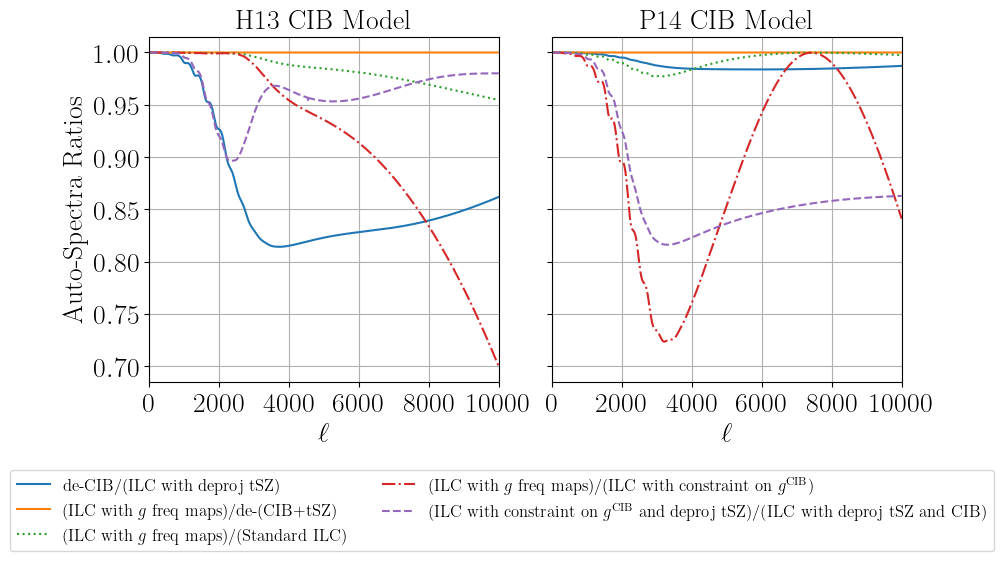

In [84]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,5), sharey=True)
linestyles = ['solid', 'solid', 'dotted', 'dashdot', 'dashed']

for p in range(2):
    
    if p==0:
        plt.axes(ax1)
        plt.plot(ells[start:stop], (m1h.Clyy/m4h.Clyy)[start:stop], label='de-CIB/(ILC with deproj tSZ)', linestyle=linestyles[0])
        plt.plot(ells[start:stop], (m2h.Clyy/m7h.Clyy)[start:stop], label=r'(ILC with $g$ freq maps)/de-(CIB+tSZ)', linestyle=linestyles[1])
        plt.plot(ells[start:stop], (m2h.Clyy/m5h.Clyy)[start:stop], label=r'(ILC with $g$ freq maps)/(Standard ILC)', linestyle=linestyles[2])
        plt.plot(ells[start:stop], (m2h.Clyy/m9h.Clyy)[start:stop], label=r'(ILC with $g$ freq maps)/(ILC with constraint on $g^{\mathrm{CIB}}$)', linestyle=linestyles[3])
        plt.plot(ells[start:stop], (m10h.Clyy/m8h.Clyy)[start:stop], label=r'(ILC with constraint on $g^{\mathrm{CIB}}$ and deproj tSZ)/(ILC with deproj tSZ and CIB)', linestyle=linestyles[4])
        plt.xlabel(r'$\ell$', font=font)
        plt.ylabel('Auto-Spectra Ratios', font=font)
        plt.xlim(0,10000)
        plt.title('H13 CIB Model', fontsize=20)
    
    elif p==1:
        plt.axes(ax2)
        plt.plot(ells[start:stop], (m1p.Clyy/m4p.Clyy)[start:stop], label='de-CIB/(ILC with deproj tSZ)', linestyle=linestyles[0])
        plt.plot(ells[start:stop], (m2p.Clyy/m7p.Clyy)[start:stop], label=r'(ILC with $g$ freq maps)/de-(CIB+tSZ)', linestyle=linestyles[1])
        plt.plot(ells[start:stop], (m2p.Clyy/m5p.Clyy)[start:stop], label=r'(ILC with $g$ freq maps)/(Standard ILC)', linestyle=linestyles[2])
        plt.plot(ells[start:stop], (m2p.Clyy/m9p.Clyy)[start:stop], label=r'(ILC with $g$ freq maps)/(ILC with constraint on $g^{\mathrm{CIB}}$)', linestyle=linestyles[3])
        plt.plot(ells[start:stop], (m10p.Clyy/m8p.Clyy)[start:stop], label=r'(ILC with constraint on $g^{\mathrm{CIB}}$ and deproj tSZ)/(ILC with deproj tSZ and CIB)', linestyle=linestyles[4])
        plt.xlabel(r'$\ell$', font=font)
        plt.xlim(0,10000)
        plt.title('P14 CIB Model', fontsize=20)
    
    plt.grid()
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    handles, labels = ax1.get_legend_handles_labels()

fig.legend(handles, labels, bbox_to_anchor=(1.06, 0.), fontsize=12, ncol=2)
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(top=0.85)
plt.savefig(f'{output_dir}/Tclean_auto_spectra_ratios.pdf', bbox_inches = "tight")
plt.show()
    
    
        

## Signal to Noise Ratio for kSZ

### $\sigma^2(C_{\ell}) = \frac{2}{(2\ell+1)f_{\rm sky}} (C_{\ell}^{\rm tot})^2$ and $\rm SNR = \sqrt{\sum_{\ell}\frac{(C_{\ell}^{\rm kSZ})^2}{\sigma^2(C_{\ell})}}$

In [85]:
def get_snr(Clyy):
    fsky = 0.4 #for SO
    sigma = 2/((2*ells+1)*fsky)*Clyy**2
    ksz_idx = spectra1.comps.index('kSZ')
    ksz = spectra1.all_spectra[ksz_idx][0][ksz_idx][0]
    ratio = ksz**2/sigma
    ratio = np.nan_to_num(ratio)
    SNR = np.sqrt(sum(ratio[2:]))
    return round(SNR,2)

In [86]:
snr_m1h = get_snr(m1h.Clyy)
snr_m2h = get_snr(m2h.Clyy)
snr_m3h = get_snr(m3h.Clyy)
snr_m4h = get_snr(m4h.Clyy)
snr_m5h = get_snr(m5h.Clyy)
snr_m6h = get_snr(m6h.Clyy)
snr_m7h = get_snr(m7h.Clyy)
snr_m8h = get_snr(m8h.Clyy)
snr_m9h = get_snr(m9h.Clyy)
snr_m10h = get_snr(m10h.Clyy)
snr_m11h = get_snr(m11h.Clyy)
print('H13 SNR for kSZ (using unWISE):')
print(f'SNR for {m5_label}:\t\t\t\t\t\t\t ', snr_m5h)
print(f'SNR for {m6_label}:\t\t\t\t\t ', snr_m6h)
print(f'SNR for {m2_label}:\t\t\t\t\t\t ', snr_m2h)
print(f'SNR for {m7_label}:\t\t\t\t\t\t\t ', snr_m7h)
print(f'SNR for {m9_label}:\t\t\t ', snr_m9h)
print(f'SNR for {m4_label}:\t\t\t\t\t\t ', snr_m4h)
print(f'SNR for {m3_label}:\t\t\t\t\t ', snr_m3h)
print(f'SNR for {m1_label}:\t\t\t\t\t\t ', snr_m1h)
print(f'SNR for {m8_label}:\t\t\t\t\t ', snr_m8h)
print(f'SNR for {m10_label}:\t\t ', snr_m10h)
print(f'SNR for {m11_label}: ', snr_m11h)
print()
snr_m1p = get_snr(m1p.Clyy)
snr_m2p = get_snr(m2p.Clyy)
snr_m3p = get_snr(m3p.Clyy)
snr_m4p = get_snr(m4p.Clyy)
snr_m5p = get_snr(m5p.Clyy)
snr_m6p = get_snr(m6p.Clyy)
snr_m7p = get_snr(m7p.Clyy)
snr_m8p = get_snr(m8p.Clyy)
snr_m9p = get_snr(m9p.Clyy)
snr_m10p = get_snr(m10p.Clyy)
snr_m11p = get_snr(m11p.Clyy)
print('P14 SNR for kSZ (using unWISE):')
print(f'SNR for {m5_label}:\t\t\t\t\t\t\t ', snr_m5p)
print(f'SNR for {m6_label}:\t\t\t\t\t ', snr_m6p)
print(f'SNR for {m2_label}:\t\t\t\t\t\t ', snr_m2p)
print(f'SNR for {m7_label}:\t\t\t\t\t\t\t ', snr_m7p)
print(f'SNR for {m9_label}:\t\t\t ', snr_m9p)
print(f'SNR for {m4_label}:\t\t\t\t\t\t ', snr_m4p)
print(f'SNR for {m3_label}:\t\t\t\t\t ', snr_m3p)
print(f'SNR for {m1_label}:\t\t\t\t\t\t ', snr_m1p)
print(f'SNR for {m8_label}:\t\t\t\t\t ', snr_m8p)
print(f'SNR for {m10_label}:\t\t ', snr_m10p)
print(f'SNR for {m11_label}: ', snr_m11p)

H13 SNR for kSZ (using unWISE):
SNR for Standard ILC:							  115.32
SNR for Standard ILC (no CIB or tSZ)*:					  202.74
SNR for ILC with $g$ freq maps:						  116.8
SNR for de-(CIB+tSZ):							  116.8
SNR for ILC with constraint on $g^{\mathrm{CIB}}$:			  110.67
SNR for ILC (deproj tSZ):						  19.43
SNR for ILC (deproj tSZ, no CIB)*:					  62.21
SNR for de-CIB (deproj tSZ):						  23.22
SNR for ILC (deproj tSZ and CIB):					  5.94
SNR for ILC with constraint on $g^{\mathrm{CIB}}$ (deproj tSZ):		  6.36
SNR for ILC with constraints on $g^{\mathrm{CIB}}$ and $g^{\mathrm{tSZ}}$:  18.74

P14 SNR for kSZ (using unWISE):
SNR for Standard ILC:							  115.25
SNR for Standard ILC (no CIB or tSZ)*:					  202.74
SNR for ILC with $g$ freq maps:						  116.75
SNR for de-(CIB+tSZ):							  116.75
SNR for ILC with constraint on $g^{\mathrm{CIB}}$:			  95.43
SNR for ILC (deproj tSZ):						  25.17
SNR for ILC (deproj tSZ, no CIB)*:					  62.21
SNR for de-CIB (deproj tSZ):						  25.52
SNR for ILC (de

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3558609562.py:6: RuntimeWarning: invalid value encountered in divide
  ratio = ksz**2/sigma


## Signal to Noise Ratio for CMB+kSZ

In [87]:
def get_snr_cmb_blackbody(Clyy):
    fsky = 0.4 #for SO
    sigma = 2/((2*ells+1)*fsky)*Clyy**2
    ksz_idx = spectra1.comps.index('kSZ')
    ksz = spectra1.all_spectra[ksz_idx][0][ksz_idx][0]
    cmb_idx = spectra1.comps.index('CMB')
    cmb = spectra1.all_spectra[cmb_idx][0][cmb_idx][0]
    ratio = (cmb+ksz)**2/sigma
    ratio = np.nan_to_num(ratio)
    SNR = np.sqrt(sum(ratio[100:]))
    return np.round(SNR,2)

In [88]:
snr_cmb_blackbody_m1h = get_snr_cmb_blackbody(m1h.Clyy)
snr_cmb_blackbody_m2h = get_snr_cmb_blackbody(m2h.Clyy)
snr_cmb_blackbody_m3h = get_snr_cmb_blackbody(m3h.Clyy)
snr_cmb_blackbody_m4h = get_snr_cmb_blackbody(m4h.Clyy)
snr_cmb_blackbody_m5h = get_snr_cmb_blackbody(m5h.Clyy)
snr_cmb_blackbody_m6h = get_snr_cmb_blackbody(m6h.Clyy)
snr_cmb_blackbody_m7h = get_snr_cmb_blackbody(m7h.Clyy)
snr_cmb_blackbody_m8h = get_snr_cmb_blackbody(m8h.Clyy)
snr_cmb_blackbody_m9h = get_snr_cmb_blackbody(m9h.Clyy)
snr_cmb_blackbody_m10h = get_snr_cmb_blackbody(m10h.Clyy)
snr_cmb_blackbody_m11h = get_snr_cmb_blackbody(m11h.Clyy)
print('H13 SNR for CMB+kSZ (using unWISE):')
print(f'SNR for {m5_label}:\t\t\t\t\t\t\t ', snr_cmb_blackbody_m5h)
print(f'SNR for {m6_label}:\t\t\t\t\t ', snr_cmb_blackbody_m6h)
print(f'SNR for {m2_label}:\t\t\t\t\t\t ', snr_cmb_blackbody_m2h)
print(f'SNR for {m7_label}:\t\t\t\t\t\t\t ', snr_cmb_blackbody_m7h)
print(f'SNR for {m9_label}:\t\t\t ', snr_cmb_blackbody_m9h)
print(f'SNR for {m4_label}:\t\t\t\t\t\t ', snr_cmb_blackbody_m4h)
print(f'SNR for {m3_label}:\t\t\t\t\t ', snr_cmb_blackbody_m3h)
print(f'SNR for {m1_label}:\t\t\t\t\t\t ', snr_cmb_blackbody_m1h)
print(f'SNR for {m8_label}:\t\t\t\t\t ', snr_cmb_blackbody_m8h)
print(f'SNR for {m10_label}:\t\t ', snr_cmb_blackbody_m10h)
print(f'SNR for {m11_label}: ', snr_cmb_blackbody_m11h)
print()
snr_cmb_blackbody_m1p = get_snr_cmb_blackbody(m1p.Clyy)
snr_cmb_blackbody_m2p = get_snr_cmb_blackbody(m2p.Clyy)
snr_cmb_blackbody_m3p = get_snr_cmb_blackbody(m3p.Clyy)
snr_cmb_blackbody_m4p = get_snr_cmb_blackbody(m4p.Clyy)
snr_cmb_blackbody_m5p = get_snr_cmb_blackbody(m5p.Clyy)
snr_cmb_blackbody_m6p = get_snr_cmb_blackbody(m6p.Clyy)
snr_cmb_blackbody_m7p = get_snr_cmb_blackbody(m7p.Clyy)
snr_cmb_blackbody_m8p = get_snr_cmb_blackbody(m8p.Clyy)
snr_cmb_blackbody_m9p = get_snr_cmb_blackbody(m9p.Clyy)
snr_cmb_blackbody_m10p = get_snr_cmb_blackbody(m10p.Clyy)
snr_cmb_blackbody_m11p = get_snr_cmb_blackbody(m11p.Clyy)
print('P14 SNR for CMB+kSZ (using unWISE):')
print(f'SNR for {m5_label}:\t\t\t\t\t\t\t ', snr_cmb_blackbody_m5p)
print(f'SNR for {m6_label}:\t\t\t\t\t ', snr_cmb_blackbody_m6p)
print(f'SNR for {m2_label}:\t\t\t\t\t\t ', snr_cmb_blackbody_m2p)
print(f'SNR for {m7_label}:\t\t\t\t\t\t\t ', snr_cmb_blackbody_m7p)
print(f'SNR for {m9_label}:\t\t\t ', snr_cmb_blackbody_m9p)
print(f'SNR for {m4_label}:\t\t\t\t\t\t ', snr_cmb_blackbody_m4p)
print(f'SNR for {m3_label}:\t\t\t\t\t ', snr_cmb_blackbody_m3p)
print(f'SNR for {m1_label}:\t\t\t\t\t\t ', snr_cmb_blackbody_m1p)
print(f'SNR for {m8_label}:\t\t\t\t\t ', snr_cmb_blackbody_m8p)
print(f'SNR for {m10_label}:\t\t ', snr_cmb_blackbody_m10p)
print(f'SNR for {m11_label}: ', snr_cmb_blackbody_m11p)

H13 SNR for CMB+kSZ (using unWISE):
SNR for Standard ILC:							  1168.84
SNR for Standard ILC (no CIB or tSZ)*:					  1326.73
SNR for ILC with $g$ freq maps:						  1170.3
SNR for de-(CIB+tSZ):							  1170.3
SNR for ILC with constraint on $g^{\mathrm{CIB}}$:			  1166.39
SNR for ILC (deproj tSZ):						  798.37
SNR for ILC (deproj tSZ, no CIB)*:					  946.23
SNR for de-CIB (deproj tSZ):						  828.71
SNR for ILC (deproj tSZ and CIB):					  686.67
SNR for ILC with constraint on $g^{\mathrm{CIB}}$ (deproj tSZ):		  700.39
SNR for ILC with constraints on $g^{\mathrm{CIB}}$ and $g^{\mathrm{tSZ}}$:  492.59

P14 SNR for CMB+kSZ (using unWISE):
SNR for Standard ILC:							  1156.47
SNR for Standard ILC (no CIB or tSZ)*:					  1326.73
SNR for ILC with $g$ freq maps:						  1168.32
SNR for de-(CIB+tSZ):							  1168.32
SNR for ILC with constraint on $g^{\mathrm{CIB}}$:			  1046.06
SNR for ILC (deproj tSZ):						  834.22
SNR for ILC (deproj tSZ, no CIB)*:					  946.23
SNR for de-CIB (deproj tSZ):

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/2021484856.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = (cmb+ksz)**2/sigma


## Tclean Auto-Spectra Forecasts for Future LSS Surveys

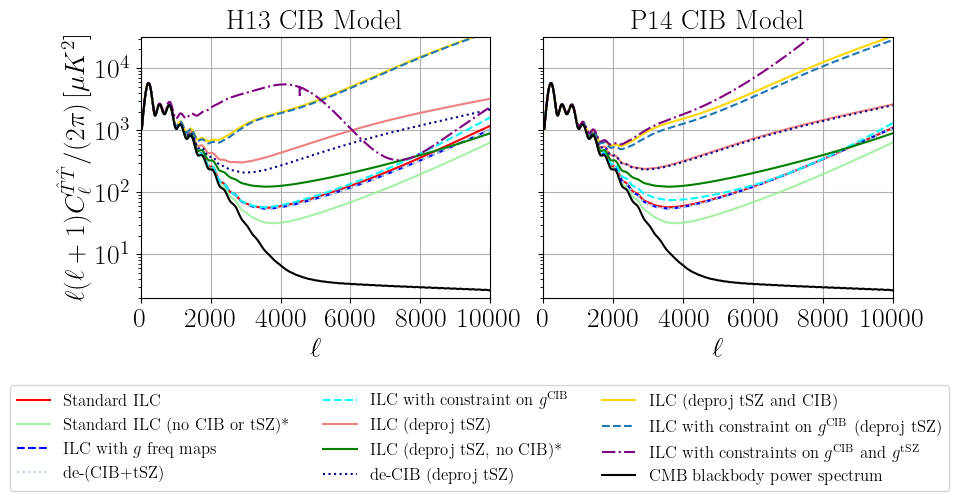

In [89]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,4), sharey=True)
ksz_idx = spectra1.comps.index('kSZ')
cmb_idx = spectra1.comps.index('CMB')

for p in range(2):
    
    if p==0:
        plt.axes(ax1)
        plt.plot(ells[start:stop], (ells*(ells+1)*m5hf.Clyy/(2*np.pi))[start:stop], label=m5_label, linestyle=m5_linestyle, color=m5_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m6hf.Clyy/(2*np.pi))[start:stop], label=m6_label, linestyle=m6_linestyle, color=m6_color, alpha=0.8)
        plt.plot(ells[start:stop], (ells*(ells+1)*m2hf.Clyy/(2*np.pi))[start:stop], label=m2_label, linestyle=m2_linestyle, color=m2_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m7hf.Clyy/(2*np.pi))[start:stop], label=m7_label, linestyle=m7_linestyle, color=m7_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m9hf.Clyy/(2*np.pi))[start:stop], label=m9_label, linestyle=m9_linestyle, color=m9_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m4hf.Clyy/(2*np.pi))[start:stop], label=m4_label, linestyle=m4_linestyle, color=m4_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m3hf.Clyy/(2*np.pi))[start:stop], label=m3_label, linestyle=m3_linestyle, color=m3_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m1hf.Clyy/(2*np.pi))[start:stop], label=m1_label, linestyle=m1_linestyle, color=m1_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m8hf.Clyy/(2*np.pi))[start:stop], label=m8_label, linestyle=m8_linestyle, color=m8_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m10hf.Clyy/(2*np.pi))[start:stop], label=m10_label, linestyle=m10_linestyle, color=m10_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m11hf.Clyy/(2*np.pi))[start:stop], label=m11_label, linestyle=m11_linestyle, color=m11_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*(ksz+cmb)/(2*np.pi))[start:stop], label='CMB blackbody power spectrum', linestyle='solid', color='k')
        plt.xlim(0,10000)
        plt.xlabel(r'$\ell$', font=font)
        plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{\hat{T}\hat{T}}/(2\pi) \, [\mu K^2]$', font=font)
        plt.yscale('log')
        plt.title('H13 CIB Model', fontsize=20)
        plt.ylim(top=10**4.5, bottom=2.)
        plt.xlim(0,10000)
    
    elif p==1:
        plt.axes(ax2)
        plt.plot(ells[start:stop], (ells*(ells+1)*m5pf.Clyy/(2*np.pi))[start:stop], label=m5_label, linestyle=m5_linestyle, color=m5_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m6pf.Clyy/(2*np.pi))[start:stop], label=m6_label, linestyle=m6_linestyle, color=m6_color, alpha=0.8)
        plt.plot(ells[start:stop], (ells*(ells+1)*m2pf.Clyy/(2*np.pi))[start:stop], label=m2_label, linestyle=m2_linestyle, color=m2_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m7pf.Clyy/(2*np.pi))[start:stop], label=m7_label, linestyle=m7_linestyle, color=m7_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m9pf.Clyy/(2*np.pi))[start:stop], label=m9_label, linestyle=m9_linestyle, color=m9_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m4pf.Clyy/(2*np.pi))[start:stop], label=m4_label, linestyle=m4_linestyle, color=m4_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m3pf.Clyy/(2*np.pi))[start:stop], label=m3_label, linestyle=m3_linestyle, color=m3_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m1pf.Clyy/(2*np.pi))[start:stop], label=m1_label, linestyle=m1_linestyle, color=m1_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m8pf.Clyy/(2*np.pi))[start:stop], label=m8_label, linestyle=m8_linestyle, color=m8_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m10pf.Clyy/(2*np.pi))[start:stop], label=m10_label, linestyle=m10_linestyle, color=m10_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*m11pf.Clyy/(2*np.pi))[start:stop], label=m11_label, linestyle=m11_linestyle, color=m11_color)
        plt.plot(ells[start:stop], (ells*(ells+1)*(ksz+cmb)/(2*np.pi))[start:stop], label='CMB blackbody power spectrum', linestyle='solid', color='k')
        plt.xlabel(r'$\ell$', font=font)
        plt.yscale('log')
        plt.title(r'P14 CIB Model', fontsize=20)
        plt.ylim(top=10**4.5, bottom=2.)
        plt.xlim(0,10000)
    
    plt.grid()
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    handles, labels = ax1.get_legend_handles_labels()

fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.), fontsize=12, ncol=3)
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(top=0.85)
plt.savefig(f'{output_dir}/Tclean_auto_spectra_lower_shot_noise.pdf', bbox_inches = "tight")
plt.show()
    
    
        

In [90]:
snr_m1hf = get_snr(m1hf.Clyy)
snr_m2hf = get_snr(m2hf.Clyy)
snr_m3hf = get_snr(m3hf.Clyy)
snr_m4hf = get_snr(m4hf.Clyy)
snr_m5hf = get_snr(m5hf.Clyy)
snr_m6hf = get_snr(m6hf.Clyy)
snr_m7hf = get_snr(m7hf.Clyy)
snr_m8hf = get_snr(m8hf.Clyy)
snr_m9hf = get_snr(m9hf.Clyy)
snr_m10hf = get_snr(m10hf.Clyy)
snr_m11hf = get_snr(m11hf.Clyy)
print('H13 SNR for kSZ (future LSS surveys):')
print(f'SNR for {m5_label}:\t\t\t\t\t\t\t ', snr_m5hf)
print(f'SNR for {m6_label}:\t\t\t\t\t ', snr_m6hf)
print(f'SNR for {m2_label}:\t\t\t\t\t\t ', snr_m2hf)
print(f'SNR for {m7_label}:\t\t\t\t\t\t\t ', snr_m7hf)
print(f'SNR for {m9_label}:\t\t\t ', snr_m9hf)
print(f'SNR for {m4_label}:\t\t\t\t\t\t ', snr_m4hf)
print(f'SNR for {m3_label}:\t\t\t\t\t ', snr_m3hf)
print(f'SNR for {m1_label}:\t\t\t\t\t\t ', snr_m1hf)
print(f'SNR for {m8_label}:\t\t\t\t\t ', snr_m8hf)
print(f'SNR for {m10_label}:\t\t ', snr_m10hf)
print(f'SNR for {m11_label}: ', snr_m11hf)
print()
snr_m1pf = get_snr(m1pf.Clyy)
snr_m2pf = get_snr(m2pf.Clyy)
snr_m3pf = get_snr(m3pf.Clyy)
snr_m4pf = get_snr(m4pf.Clyy)
snr_m5pf = get_snr(m5pf.Clyy)
snr_m6pf = get_snr(m6pf.Clyy)
snr_m7pf = get_snr(m7pf.Clyy)
snr_m8pf = get_snr(m8pf.Clyy)
snr_m9pf = get_snr(m9pf.Clyy)
snr_m10pf = get_snr(m10pf.Clyy)
snr_m11pf = get_snr(m11pf.Clyy)
print('P14 SNR for kSZ (future LSS surveys):')
print(f'SNR for {m5_label}:\t\t\t\t\t\t\t ', snr_m5pf)
print(f'SNR for {m6_label}:\t\t\t\t\t ', snr_m6pf)
print(f'SNR for {m2_label}:\t\t\t\t\t\t ', snr_m2pf)
print(f'SNR for {m7_label}:\t\t\t\t\t\t\t ', snr_m7pf)
print(f'SNR for {m9_label}:\t\t\t ', snr_m9pf)
print(f'SNR for {m4_label}:\t\t\t\t\t\t ', snr_m4pf)
print(f'SNR for {m3_label}:\t\t\t\t\t ', snr_m3pf)
print(f'SNR for {m1_label}:\t\t\t\t\t\t ', snr_m1pf)
print(f'SNR for {m8_label}:\t\t\t\t\t ', snr_m8pf)
print(f'SNR for {m10_label}:\t\t ', snr_m10pf)
print(f'SNR for {m11_label}: ', snr_m11pf)

H13 SNR for kSZ (future LSS surveys):
SNR for Standard ILC:							  115.32
SNR for Standard ILC (no CIB or tSZ)*:					  202.74
SNR for ILC with $g$ freq maps:						  120.04
SNR for de-(CIB+tSZ):							  120.04
SNR for ILC with constraint on $g^{\mathrm{CIB}}$:			  110.58
SNR for ILC (deproj tSZ):						  19.43
SNR for ILC (deproj tSZ, no CIB)*:					  62.21
SNR for de-CIB (deproj tSZ):						  29.25
SNR for ILC (deproj tSZ and CIB):					  5.94
SNR for ILC with constraint on $g^{\mathrm{CIB}}$ (deproj tSZ):		  6.34
SNR for ILC with constraints on $g^{\mathrm{CIB}}$ and $g^{\mathrm{tSZ}}$:  19.72

P14 SNR for kSZ (future LSS surveys):
SNR for Standard ILC:							  115.25
SNR for Standard ILC (no CIB or tSZ)*:					  202.74
SNR for ILC with $g$ freq maps:						  118.37
SNR for de-(CIB+tSZ):							  118.37
SNR for ILC with constraint on $g^{\mathrm{CIB}}$:			  96.65
SNR for ILC (deproj tSZ):						  25.17
SNR for ILC (deproj tSZ, no CIB)*:					  62.21
SNR for de-CIB (deproj tSZ):						  25.93
S

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/3558609562.py:6: RuntimeWarning: invalid value encountered in divide
  ratio = ksz**2/sigma


In [91]:
snr_cmb_blackbody_m1hf = get_snr_cmb_blackbody(m1hf.Clyy)
snr_cmb_blackbody_m2hf = get_snr_cmb_blackbody(m2hf.Clyy)
snr_cmb_blackbody_m3hf = get_snr_cmb_blackbody(m3hf.Clyy)
snr_cmb_blackbody_m4hf = get_snr_cmb_blackbody(m4hf.Clyy)
snr_cmb_blackbody_m5hf = get_snr_cmb_blackbody(m5hf.Clyy)
snr_cmb_blackbody_m6hf = get_snr_cmb_blackbody(m6hf.Clyy)
snr_cmb_blackbody_m7hf = get_snr_cmb_blackbody(m7hf.Clyy)
snr_cmb_blackbody_m8hf = get_snr_cmb_blackbody(m8hf.Clyy)
snr_cmb_blackbody_m9hf = get_snr_cmb_blackbody(m9hf.Clyy)
snr_cmb_blackbody_m10hf = get_snr_cmb_blackbody(m10hf.Clyy)
snr_cmb_blackbody_m11hf = get_snr_cmb_blackbody(m11hf.Clyy)
print('H13 SNR for CMB+kSZ (future LSS surveys):')
print(f'SNR for {m5_label}:\t\t\t\t\t\t\t ', snr_cmb_blackbody_m5hf)
print(f'SNR for {m6_label}:\t\t\t\t\t ', snr_cmb_blackbody_m6hf)
print(f'SNR for {m2_label}:\t\t\t\t\t\t ', snr_cmb_blackbody_m2hf)
print(f'SNR for {m7_label}:\t\t\t\t\t\t\t ', snr_cmb_blackbody_m7hf)
print(f'SNR for {m9_label}:\t\t\t ', snr_cmb_blackbody_m9hf)
print(f'SNR for {m4_label}:\t\t\t\t\t\t ', snr_cmb_blackbody_m4hf)
print(f'SNR for {m3_label}:\t\t\t\t\t ', snr_cmb_blackbody_m3hf)
print(f'SNR for {m1_label}:\t\t\t\t\t\t ', snr_cmb_blackbody_m1hf)
print(f'SNR for {m8_label}:\t\t\t\t\t ', snr_cmb_blackbody_m8hf)
print(f'SNR for {m10_label}:\t\t ', snr_cmb_blackbody_m10hf)
print(f'SNR for {m11_label}: ', snr_cmb_blackbody_m11hf)
print()
snr_cmb_blackbody_m1pf = get_snr_cmb_blackbody(m1pf.Clyy)
snr_cmb_blackbody_m2pf = get_snr_cmb_blackbody(m2pf.Clyy)
snr_cmb_blackbody_m3pf = get_snr_cmb_blackbody(m3pf.Clyy)
snr_cmb_blackbody_m4pf = get_snr_cmb_blackbody(m4pf.Clyy)
snr_cmb_blackbody_m5pf = get_snr_cmb_blackbody(m5pf.Clyy)
snr_cmb_blackbody_m6pf = get_snr_cmb_blackbody(m6pf.Clyy)
snr_cmb_blackbody_m7pf = get_snr_cmb_blackbody(m7pf.Clyy)
snr_cmb_blackbody_m8pf = get_snr_cmb_blackbody(m8pf.Clyy)
snr_cmb_blackbody_m9pf = get_snr_cmb_blackbody(m9pf.Clyy)
snr_cmb_blackbody_m10pf = get_snr_cmb_blackbody(m10pf.Clyy)
snr_cmb_blackbody_m11pf = get_snr_cmb_blackbody(m11pf.Clyy)
print('P14 SNR for CMB+kSZ (future LSS surveys):')
print(f'SNR for {m5_label}:\t\t\t\t\t\t\t ', snr_cmb_blackbody_m5pf)
print(f'SNR for {m6_label}:\t\t\t\t\t ', snr_cmb_blackbody_m6pf)
print(f'SNR for {m2_label}:\t\t\t\t\t\t ', snr_cmb_blackbody_m2pf)
print(f'SNR for {m7_label}:\t\t\t\t\t\t\t ', snr_cmb_blackbody_m7pf)
print(f'SNR for {m9_label}:\t\t\t ', snr_cmb_blackbody_m9pf)
print(f'SNR for {m4_label}:\t\t\t\t\t\t ', snr_cmb_blackbody_m4pf)
print(f'SNR for {m3_label}:\t\t\t\t\t ', snr_cmb_blackbody_m3pf)
print(f'SNR for {m1_label}:\t\t\t\t\t\t ', snr_cmb_blackbody_m1pf)
print(f'SNR for {m8_label}:\t\t\t\t\t ', snr_cmb_blackbody_m8pf)
print(f'SNR for {m10_label}:\t\t ', snr_cmb_blackbody_m10pf)
print(f'SNR for {m11_label}: ', snr_cmb_blackbody_m11pf)

H13 SNR for CMB+kSZ (future LSS surveys):
SNR for Standard ILC:							  1168.84
SNR for Standard ILC (no CIB or tSZ)*:					  1326.73
SNR for ILC with $g$ freq maps:						  1172.69
SNR for de-(CIB+tSZ):							  1172.62
SNR for ILC with constraint on $g^{\mathrm{CIB}}$:			  1166.25
SNR for ILC (deproj tSZ):						  798.37
SNR for ILC (deproj tSZ, no CIB)*:					  946.23
SNR for de-CIB (deproj tSZ):						  857.11
SNR for ILC (deproj tSZ and CIB):					  686.67
SNR for ILC with constraint on $g^{\mathrm{CIB}}$ (deproj tSZ):		  699.57
SNR for ILC with constraints on $g^{\mathrm{CIB}}$ and $g^{\mathrm{tSZ}}$:  503.45

P14 SNR for CMB+kSZ (future LSS surveys):
SNR for Standard ILC:							  1156.47
SNR for Standard ILC (no CIB or tSZ)*:					  1326.73
SNR for ILC with $g$ freq maps:						  1178.59
SNR for de-(CIB+tSZ):							  1178.59
SNR for ILC with constraint on $g^{\mathrm{CIB}}$:			  1053.8
SNR for ILC (deproj tSZ):						  834.22
SNR for ILC (deproj tSZ, no CIB)*:					  946.23
SNR for de-CIB 

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_2449/2021484856.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = (cmb+ksz)**2/sigma


## Print CIB Shot Noise in $Jy^2/sr$

In [92]:
def get_cib_shot_noise():
    #from table 6 of Planck Collaboration: CIB Anisotropies with Planck
    planck_freqs = np.array([545, 353, 217, 143, 100]) #we only use 353, 217, 100
    all_freqs = np.array([545, 353, 280, 225, 217, 145, 143, 100, 93])
    shot_noise_545 = np.array([1454, 543, 135, 35, 12])
    shot_noise_353 = np.array([543, 225, 59, 15, 5.4])
    shot_noise_217 = np.array([135, 59, 16, 4.3, 1.5])
    shot_noise_143 = np.array([35, 15, 4.3, 1.2, 0.42])
    shot_noise_100 = np.array([12, 5.4, 1.5, 0.42, 0.15])
    planck_shot_noise = np.array([shot_noise_545, shot_noise_353, shot_noise_217, shot_noise_143, shot_noise_100])
    for i in range(len(planck_shot_noise)):
        for j in range(len(planck_shot_noise[0])):
            freq1, freq2 = planck_freqs[i], planck_freqs[j]
            equiv1 = u.thermodynamic_temperature(freq1 * u.GHz, Planck15.Tcmb0)
            planck_shot_noise[i][j] *= (1. * u.Jy / u.sr).to(u.uK, equivalencies=equiv1).value
            equiv2 = u.thermodynamic_temperature(freq2 * u.GHz, Planck15.Tcmb0)
            planck_shot_noise[i][j] *= (1. * u.Jy / u.sr).to(u.uK, equivalencies=equiv2).value

    #get planck x (planck and SO)
    planck_shot_noise_log = np.log(planck_shot_noise)
    planck_cross_all_shot_noise = np.zeros((5, len(all_freqs)))
    for i, sn in enumerate(planck_shot_noise_log):
        f = interp1d(planck_freqs, sn, fill_value='extrapolate')
        planck_cross_all_shot_noise[i] = np.exp(f(all_freqs))

    #get (planck and SO) x (planck and SO)
    all_cross_planck_shot_noise = planck_cross_all_shot_noise.T
    all_cross_planck_shot_noise_log = np.log(all_cross_planck_shot_noise)
    all_shot_noise = np.zeros((len(all_freqs), len(all_freqs)))
    for i, sn in enumerate(all_cross_planck_shot_noise_log):
        f = interp1d(planck_freqs, sn, fill_value='extrapolate')
        all_shot_noise[i] = np.exp(f(all_freqs))

    all_shot_noise = np.flip(all_shot_noise)
    return all_shot_noise

all_shot_noise = get_cib_shot_noise()


all_freqs = np.flip(np.array([545, 353, 280, 225, 217, 145, 143, 100, 93]))
for i in range(len(all_freqs)):
    for j in range(len(all_freqs)):
            freq1, freq2 = all_freqs[i], all_freqs[j]
            equiv1 = u.thermodynamic_temperature(freq1 * u.GHz, Planck15.Tcmb0)
            all_shot_noise[i][j] *= (u.uK).to(1. * u.Jy / u.sr, equivalencies=equiv1)
            equiv2 = u.thermodynamic_temperature(freq2 * u.GHz, Planck15.Tcmb0)
            all_shot_noise[i][j] *= (u.uK).to(1. * u.Jy / u.sr, equivalencies=equiv2)
np.set_printoptions(suppress=True)
print(all_shot_noise)
np.set_printoptions(suppress=False)


[[   0.09983621    0.12234139    0.34143114    0.35612873    1.21873653
     1.35024244    2.46062806    4.41000679    9.72248594]
 [   0.12234139    0.15          0.42          0.43808616    1.5
     1.66135402    3.02131363    5.4          12.        ]
 [   0.34143114    0.42          1.2           1.25178732    4.3
     4.75373201    8.53563995   15.           35.        ]
 [   0.35612873    0.43808616    1.25178732    1.30584552    4.4901416
     4.9643753     8.91927415   15.68680294   36.5831949 ]
 [   1.21873653    1.5           4.3           4.4901416    16.
    17.74616078   32.58786127   59.          135.        ]
 [   1.35024244    1.66135402    4.75373201    4.9643753    17.74616078
    19.68517841   36.177461     65.5684889   150.50046675]
 [   2.46062806    3.02131363    8.53563995    8.91927415   32.58786127
    36.177461     66.85353517  122.05355059  286.25256048]
 [   4.41000679    5.4          15.           15.68680294   59.
    65.5684889   122.05355059  225.       